In [0]:
# !kill -9 -1

In [1]:
!ls

datalab


In [2]:
!git clone https://github.com/daniarnaizg/text-detector-ocr.git

Cloning into 'text-detector-ocr'...
remote: Counting objects: 58, done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 58 (delta 15), reused 45 (delta 8), pack-reused 0
Unpacking objects: 100% (58/58), done.
Checking out files: 100% (17/17), done.


In [3]:
!ls text-detector-ocr/Resources/datasets

cifar10-png.zip  MSRA-TD500.zip


In [4]:
!wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz;
!tar -xzvf EnglishImg.tgz

--2018-05-10 00:32:00--  http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz
Resolving www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)... 131.227.80.48
Connecting to www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)|131.227.80.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133975105 (128M) [application/x-gzip]
Saving to: ‘EnglishImg.tgz’

EnglishImg.tgz      100%[===================>] 127.77M  30.2MB/s    in 4.8s    

2018-05-10 00:32:05 (26.5 MB/s) - ‘EnglishImg.tgz’ saved [133975105/133975105]

English/Img/
English/Img/BadImag/
English/Img/BadImag/Bmp/
English/Img/BadImag/Bmp/Sample029/
English/Img/BadImag/Bmp/Sample029/img029-00006.png
English/Img/BadImag/Bmp/Sample029/img029-00007.png
English/Img/BadImag/Bmp/Sample029/img029-00008.png
English/Img/BadImag/Bmp/Sample029/img029-00009.png
English/Img/BadImag/Bmp/Sample029/img029-00010.png
English/Img/BadImag/Bmp/Sample029/img029-00011.png
English/Img/BadImag/Bmp/Sample029/img029-00012.png
English/Img/BadImag/B

English/Img/BadImag/Bmp/Sample057/img057-00024.png
English/Img/BadImag/Bmp/Sample057/img057-00025.png
English/Img/BadImag/Bmp/Sample057/img057-00026.png
English/Img/BadImag/Bmp/Sample057/img057-00027.png
English/Img/BadImag/Bmp/Sample057/img057-00028.png
English/Img/BadImag/Bmp/Sample057/img057-00029.png
English/Img/BadImag/Bmp/Sample057/img057-00030.png
English/Img/BadImag/Bmp/Sample057/img057-00031.png
English/Img/BadImag/Bmp/Sample057/img057-00032.png
English/Img/BadImag/Bmp/Sample057/img057-00033.png
English/Img/BadImag/Bmp/Sample057/img057-00034.png
English/Img/BadImag/Bmp/Sample057/img057-00035.png
English/Img/BadImag/Bmp/Sample057/img057-00036.png
English/Img/BadImag/Bmp/Sample057/img057-00001.png
English/Img/BadImag/Bmp/Sample057/img057-00002.png
English/Img/BadImag/Bmp/Sample057/img057-00003.png
English/Img/BadImag/Bmp/Sample057/img057-00004.png
English/Img/BadImag/Bmp/Sample058/
English/Img/BadImag/Bmp/Sample058/img058-00001.png
English/Img/BadImag/Bmp/Sample058/img058-00002.

English/Img/BadImag/Bmp/Sample011/img011-00001.png
English/Img/BadImag/Bmp/Sample011/img011-00002.png
English/Img/BadImag/Bmp/Sample011/img011-00003.png
English/Img/BadImag/Bmp/Sample011/img011-00004.png
English/Img/BadImag/Bmp/Sample011/img011-00295.png
English/Img/BadImag/Bmp/Sample011/img011-00296.png
English/Img/BadImag/Bmp/Sample011/img011-00297.png
English/Img/BadImag/Bmp/Sample011/img011-00298.png
English/Img/BadImag/Bmp/Sample011/img011-00299.png
English/Img/BadImag/Bmp/Sample011/img011-00300.png
English/Img/BadImag/Bmp/Sample011/img011-00301.png
English/Img/BadImag/Bmp/Sample011/img011-00302.png
English/Img/BadImag/Bmp/Sample011/img011-00303.png
English/Img/BadImag/Bmp/Sample011/img011-00304.png
English/Img/BadImag/Bmp/Sample011/img011-00305.png
English/Img/BadImag/Bmp/Sample011/img011-00306.png
English/Img/BadImag/Bmp/Sample011/img011-00307.png
English/Img/BadImag/Bmp/Sample011/img011-00308.png
English/Img/BadImag/Bmp/Sample011/img011-00309.png
English/Img/BadImag/Bmp/Sample0

English/Img/BadImag/Bmp/Sample017/img017-00037.png
English/Img/BadImag/Bmp/Sample017/img017-00038.png
English/Img/BadImag/Bmp/Sample017/img017-00040.png
English/Img/BadImag/Bmp/Sample017/img017-00041.png
English/Img/BadImag/Bmp/Sample017/img017-00042.png
English/Img/BadImag/Bmp/Sample017/img017-00043.png
English/Img/BadImag/Bmp/Sample017/img017-00044.png
English/Img/BadImag/Bmp/Sample017/img017-00045.png
English/Img/BadImag/Bmp/Sample017/img017-00046.png
English/Img/BadImag/Bmp/Sample017/img017-00047.png
English/Img/BadImag/Bmp/Sample017/img017-00048.png
English/Img/BadImag/Bmp/Sample017/img017-00049.png
English/Img/BadImag/Bmp/Sample017/img017-00050.png
English/Img/BadImag/Bmp/Sample017/img017-00051.png
English/Img/BadImag/Bmp/Sample017/img017-00052.png
English/Img/BadImag/Bmp/Sample017/img017-00053.png
English/Img/BadImag/Bmp/Sample017/img017-00054.png
English/Img/BadImag/Bmp/Sample017/img017-00055.png
English/Img/BadImag/Bmp/Sample017/img017-00005.png
English/Img/BadImag/Bmp/Sample0

English/Img/BadImag/Bmp/Sample022/img022-00110.png
English/Img/BadImag/Bmp/Sample022/img022-00111.png
English/Img/BadImag/Bmp/Sample022/img022-00112.png
English/Img/BadImag/Bmp/Sample022/img022-00113.png
English/Img/BadImag/Bmp/Sample022/img022-00114.png
English/Img/BadImag/Bmp/Sample022/img022-00115.png
English/Img/BadImag/Bmp/Sample022/img022-00116.png
English/Img/BadImag/Bmp/Sample022/img022-00117.png
English/Img/BadImag/Bmp/Sample022/img022-00118.png
English/Img/BadImag/Bmp/Sample022/img022-00119.png
English/Img/BadImag/Bmp/Sample023/
English/Img/BadImag/Bmp/Sample023/img023-00006.png
English/Img/BadImag/Bmp/Sample023/img023-00007.png
English/Img/BadImag/Bmp/Sample023/img023-00008.png
English/Img/BadImag/Bmp/Sample023/img023-00009.png
English/Img/BadImag/Bmp/Sample023/img023-00010.png
English/Img/BadImag/Bmp/Sample023/img023-00011.png
English/Img/BadImag/Bmp/Sample023/img023-00012.png
English/Img/BadImag/Bmp/Sample023/img023-00013.png
English/Img/BadImag/Bmp/Sample023/img023-00014.

English/Img/BadImag/Bmp/Sample028/img028-00056.png
English/Img/BadImag/Bmp/Sample028/img028-00073.png
English/Img/BadImag/Bmp/Sample028/img028-00090.png
English/Img/BadImag/Bmp/Sample028/img028-00107.png
English/Img/BadImag/Bmp/Sample028/img028-00124.png
English/Img/BadImag/Bmp/Sample028/img028-00141.png
English/Img/BadImag/Bmp/Sample028/img028-00158.png
English/Img/BadImag/Bmp/Sample028/img028-00175.png
English/Img/BadImag/Bmp/Sample028/img028-00192.png
English/Img/BadImag/Bmp/Sample028/img028-00209.png
English/Img/BadImag/Bmp/Sample028/img028-00057.png
English/Img/BadImag/Bmp/Sample028/img028-00058.png
English/Img/BadImag/Bmp/Sample028/img028-00059.png
English/Img/BadImag/Bmp/Sample028/img028-00060.png
English/Img/BadImag/Bmp/Sample028/img028-00061.png
English/Img/BadImag/Bmp/Sample028/img028-00062.png
English/Img/BadImag/Bmp/Sample028/img028-00063.png
English/Img/BadImag/Bmp/Sample028/img028-00064.png
English/Img/BadImag/Bmp/Sample028/img028-00065.png
English/Img/BadImag/Bmp/Sample0

English/Img/BadImag/Bmp/Sample037/img037-00015.png
English/Img/BadImag/Bmp/Sample037/img037-00016.png
English/Img/BadImag/Bmp/Sample037/img037-00017.png
English/Img/BadImag/Bmp/Sample037/img037-00018.png
English/Img/BadImag/Bmp/Sample037/img037-00019.png
English/Img/BadImag/Bmp/Sample037/img037-00020.png
English/Img/BadImag/Bmp/Sample037/img037-00021.png
English/Img/BadImag/Bmp/Sample037/img037-00023.png
English/Img/BadImag/Bmp/Sample037/img037-00024.png
English/Img/BadImag/Bmp/Sample037/img037-00025.png
English/Img/BadImag/Bmp/Sample037/img037-00026.png
English/Img/BadImag/Bmp/Sample037/img037-00027.png
English/Img/BadImag/Bmp/Sample037/img037-00028.png
English/Img/BadImag/Bmp/Sample037/img037-00029.png
English/Img/BadImag/Bmp/Sample037/img037-00030.png
English/Img/BadImag/Bmp/Sample037/img037-00031.png
English/Img/BadImag/Bmp/Sample037/img037-00032.png
English/Img/BadImag/Bmp/Sample037/img037-00033.png
English/Img/BadImag/Bmp/Sample037/img037-00034.png
English/Img/BadImag/Bmp/Sample0

English/Img/BadImag/Bmp/Sample047/img047-00016.png
English/Img/BadImag/Bmp/Sample047/img047-00017.png
English/Img/BadImag/Msk/
English/Img/BadImag/Msk/Sample029/
English/Img/BadImag/Msk/Sample029/img029-00006.png
English/Img/BadImag/Msk/Sample029/img029-00007.png
English/Img/BadImag/Msk/Sample029/img029-00008.png
English/Img/BadImag/Msk/Sample029/img029-00009.png
English/Img/BadImag/Msk/Sample029/img029-00010.png
English/Img/BadImag/Msk/Sample029/img029-00011.png
English/Img/BadImag/Msk/Sample029/img029-00012.png
English/Img/BadImag/Msk/Sample029/img029-00013.png
English/Img/BadImag/Msk/Sample029/img029-00014.png
English/Img/BadImag/Msk/Sample029/img029-00015.png
English/Img/BadImag/Msk/Sample029/img029-00016.png
English/Img/BadImag/Msk/Sample029/img029-00017.png
English/Img/BadImag/Msk/Sample029/img029-00018.png
English/Img/BadImag/Msk/Sample029/img029-00019.png
English/Img/BadImag/Msk/Sample029/img029-00020.png
English/Img/BadImag/Msk/Sample029/img029-00021.png
English/Img/BadImag/Ms

English/Img/BadImag/Msk/Sample056/img056-00061.png
English/Img/BadImag/Msk/Sample056/img056-00062.png
English/Img/BadImag/Msk/Sample056/img056-00063.png
English/Img/BadImag/Msk/Sample056/img056-00064.png
English/Img/BadImag/Msk/Sample056/img056-00065.png
English/Img/BadImag/Msk/Sample056/img056-00066.png
English/Img/BadImag/Msk/Sample056/img056-00067.png
English/Img/BadImag/Msk/Sample056/img056-00068.png
English/Img/BadImag/Msk/Sample056/img056-00069.png
English/Img/BadImag/Msk/Sample056/img056-00070.png
English/Img/BadImag/Msk/Sample056/img056-00071.png
English/Img/BadImag/Msk/Sample056/img056-00072.png
English/Img/BadImag/Msk/Sample056/img056-00074.png
English/Img/BadImag/Msk/Sample056/img056-00075.png
English/Img/BadImag/Msk/Sample056/img056-00076.png
English/Img/BadImag/Msk/Sample056/img056-00077.png
English/Img/BadImag/Msk/Sample056/img056-00078.png
English/Img/BadImag/Msk/Sample056/img056-00079.png
English/Img/BadImag/Msk/Sample056/img056-00080.png
English/Img/BadImag/Msk/Sample0

English/Img/BadImag/Msk/Sample015/img015-00020.png
English/Img/BadImag/Msk/Sample015/img015-00021.png
English/Img/BadImag/Msk/Sample015/img015-00023.png
English/Img/BadImag/Msk/Sample015/img015-00024.png
English/Img/BadImag/Msk/Sample015/img015-00025.png
English/Img/BadImag/Msk/Sample015/img015-00026.png
English/Img/BadImag/Msk/Sample015/img015-00027.png
English/Img/BadImag/Msk/Sample015/img015-00028.png
English/Img/BadImag/Msk/Sample015/img015-00029.png
English/Img/BadImag/Msk/Sample015/img015-00030.png
English/Img/BadImag/Msk/Sample015/img015-00031.png
English/Img/BadImag/Msk/Sample015/img015-00032.png
English/Img/BadImag/Msk/Sample015/img015-00033.png
English/Img/BadImag/Msk/Sample015/img015-00034.png
English/Img/BadImag/Msk/Sample015/img015-00035.png
English/Img/BadImag/Msk/Sample015/img015-00036.png
English/Img/BadImag/Msk/Sample015/img015-00037.png
English/Img/BadImag/Msk/Sample015/img015-00038.png
English/Img/BadImag/Msk/Sample015/img015-00040.png
English/Img/BadImag/Msk/Sample0

English/Img/BadImag/Msk/Sample024/img024-00067.png
English/Img/BadImag/Msk/Sample024/img024-00068.png
English/Img/BadImag/Msk/Sample024/img024-00069.png
English/Img/BadImag/Msk/Sample024/img024-00070.png
English/Img/BadImag/Msk/Sample024/img024-00071.png
English/Img/BadImag/Msk/Sample024/img024-00072.png
English/Img/BadImag/Msk/Sample024/img024-00074.png
English/Img/BadImag/Msk/Sample024/img024-00075.png
English/Img/BadImag/Msk/Sample024/img024-00076.png
English/Img/BadImag/Msk/Sample024/img024-00077.png
English/Img/BadImag/Msk/Sample024/img024-00078.png
English/Img/BadImag/Msk/Sample024/img024-00079.png
English/Img/BadImag/Msk/Sample024/img024-00080.png
English/Img/BadImag/Msk/Sample024/img024-00081.png
English/Img/BadImag/Msk/Sample024/img024-00082.png
English/Img/BadImag/Msk/Sample024/img024-00083.png
English/Img/BadImag/Msk/Sample024/img024-00084.png
English/Img/BadImag/Msk/Sample024/img024-00085.png
English/Img/BadImag/Msk/Sample024/img024-00086.png
English/Img/BadImag/Msk/Sample0

English/Img/BadImag/Msk/Sample033/img033-00037.png
English/Img/BadImag/Msk/Sample033/img033-00038.png
English/Img/BadImag/Msk/Sample033/img033-00039.png
English/Img/BadImag/Msk/Sample033/img033-00040.png
English/Img/BadImag/Msk/Sample033/img033-00041.png
English/Img/BadImag/Msk/Sample033/img033-00042.png
English/Img/BadImag/Msk/Sample033/img033-00043.png
English/Img/BadImag/Msk/Sample033/img033-00044.png
English/Img/BadImag/Msk/Sample033/img033-00045.png
English/Img/BadImag/Msk/Sample033/img033-00001.png
English/Img/BadImag/Msk/Sample033/img033-00002.png
English/Img/BadImag/Msk/Sample033/img033-00003.png
English/Img/BadImag/Msk/Sample033/img033-00004.png
English/Img/BadImag/Msk/Sample034/
English/Img/BadImag/Msk/Sample034/img034-00001.png
English/Img/BadImag/Msk/Sample034/img034-00002.png
English/Img/BadImag/Msk/Sample034/img034-00003.png
English/Img/BadImag/Msk/Sample034/img034-00004.png
English/Img/BadImag/Msk/Sample034/img034-00005.png
English/Img/BadImag/Msk/Sample034/img034-00006.

English/Img/GoodImg/Bmp/Sample029/img029-00111.png
English/Img/GoodImg/Bmp/Sample029/img029-00112.png
English/Img/GoodImg/Bmp/Sample029/img029-00113.png
English/Img/GoodImg/Bmp/Sample029/img029-00114.png
English/Img/GoodImg/Bmp/Sample029/img029-00115.png
English/Img/GoodImg/Bmp/Sample029/img029-00116.png
English/Img/GoodImg/Bmp/Sample029/img029-00117.png
English/Img/GoodImg/Bmp/Sample029/img029-00118.png
English/Img/GoodImg/Bmp/Sample029/img029-00119.png
English/Img/GoodImg/Bmp/Sample029/img029-00120.png
English/Img/GoodImg/Bmp/Sample029/img029-00121.png
English/Img/GoodImg/Bmp/Sample029/img029-00122.png
English/Img/GoodImg/Bmp/Sample029/img029-00123.png
English/Img/GoodImg/Bmp/Sample029/img029-00125.png
English/Img/GoodImg/Bmp/Sample029/img029-00126.png
English/Img/GoodImg/Bmp/Sample029/img029-00127.png
English/Img/GoodImg/Bmp/Sample029/img029-00128.png
English/Img/GoodImg/Bmp/Sample029/img029-00129.png
English/Img/GoodImg/Bmp/Sample029/img029-00130.png
English/Img/GoodImg/Bmp/Sample0

English/Img/GoodImg/Bmp/Sample054/img054-00033.png
English/Img/GoodImg/Bmp/Sample054/img054-00034.png
English/Img/GoodImg/Bmp/Sample054/img054-00035.png
English/Img/GoodImg/Bmp/Sample054/img054-00036.png
English/Img/GoodImg/Bmp/Sample054/img054-00037.png
English/Img/GoodImg/Bmp/Sample054/img054-00038.png
English/Img/GoodImg/Bmp/Sample054/img054-00040.png
English/Img/GoodImg/Bmp/Sample054/img054-00041.png
English/Img/GoodImg/Bmp/Sample054/img054-00042.png
English/Img/GoodImg/Bmp/Sample054/img054-00043.png
English/Img/GoodImg/Bmp/Sample054/img054-00044.png
English/Img/GoodImg/Bmp/Sample054/img054-00045.png
English/Img/GoodImg/Bmp/Sample054/img054-00046.png
English/Img/GoodImg/Bmp/Sample054/img054-00047.png
English/Img/GoodImg/Bmp/Sample054/img054-00048.png
English/Img/GoodImg/Bmp/Sample054/img054-00049.png
English/Img/GoodImg/Bmp/Sample054/img054-00050.png
English/Img/GoodImg/Bmp/Sample054/img054-00051.png
English/Img/GoodImg/Bmp/Sample054/img054-00052.png
English/Img/GoodImg/Bmp/Sample0

English/Img/GoodImg/Bmp/Sample002/img002-00010.png
English/Img/GoodImg/Bmp/Sample002/img002-00011.png
English/Img/GoodImg/Bmp/Sample002/img002-00012.png
English/Img/GoodImg/Bmp/Sample002/img002-00013.png
English/Img/GoodImg/Bmp/Sample002/img002-00014.png
English/Img/GoodImg/Bmp/Sample002/img002-00015.png
English/Img/GoodImg/Bmp/Sample002/img002-00016.png
English/Img/GoodImg/Bmp/Sample002/img002-00017.png
English/Img/GoodImg/Bmp/Sample002/img002-00018.png
English/Img/GoodImg/Bmp/Sample002/img002-00019.png
English/Img/GoodImg/Bmp/Sample002/img002-00020.png
English/Img/GoodImg/Bmp/Sample002/img002-00021.png
English/Img/GoodImg/Bmp/Sample002/img002-00023.png
English/Img/GoodImg/Bmp/Sample002/img002-00024.png
English/Img/GoodImg/Bmp/Sample002/img002-00025.png
English/Img/GoodImg/Bmp/Sample002/img002-00026.png
English/Img/GoodImg/Bmp/Sample002/img002-00027.png
English/Img/GoodImg/Bmp/Sample002/img002-00028.png
English/Img/GoodImg/Bmp/Sample002/img002-00029.png
English/Img/GoodImg/Bmp/Sample0

English/Img/GoodImg/Bmp/Sample011/img011-00129.png
English/Img/GoodImg/Bmp/Sample011/img011-00130.png
English/Img/GoodImg/Bmp/Sample011/img011-00131.png
English/Img/GoodImg/Bmp/Sample011/img011-00132.png
English/Img/GoodImg/Bmp/Sample011/img011-00133.png
English/Img/GoodImg/Bmp/Sample011/img011-00134.png
English/Img/GoodImg/Bmp/Sample011/img011-00135.png
English/Img/GoodImg/Bmp/Sample011/img011-00136.png
English/Img/GoodImg/Bmp/Sample011/img011-00137.png
English/Img/GoodImg/Bmp/Sample011/img011-00138.png
English/Img/GoodImg/Bmp/Sample011/img011-00139.png
English/Img/GoodImg/Bmp/Sample011/img011-00140.png
English/Img/GoodImg/Bmp/Sample011/img011-00142.png
English/Img/GoodImg/Bmp/Sample011/img011-00143.png
English/Img/GoodImg/Bmp/Sample011/img011-00144.png
English/Img/GoodImg/Bmp/Sample011/img011-00145.png
English/Img/GoodImg/Bmp/Sample011/img011-00146.png
English/Img/GoodImg/Bmp/Sample011/img011-00147.png
English/Img/GoodImg/Bmp/Sample011/img011-00148.png
English/Img/GoodImg/Bmp/Sample0

English/Img/GoodImg/Bmp/Sample013/img013-00146.png
English/Img/GoodImg/Bmp/Sample013/img013-00147.png
English/Img/GoodImg/Bmp/Sample013/img013-00148.png
English/Img/GoodImg/Bmp/Sample013/img013-00149.png
English/Img/GoodImg/Bmp/Sample013/img013-00150.png
English/Img/GoodImg/Bmp/Sample013/img013-00151.png
English/Img/GoodImg/Bmp/Sample013/img013-00152.png
English/Img/GoodImg/Bmp/Sample013/img013-00153.png
English/Img/GoodImg/Bmp/Sample013/img013-00154.png
English/Img/GoodImg/Bmp/Sample013/img013-00155.png
English/Img/GoodImg/Bmp/Sample013/img013-00156.png
English/Img/GoodImg/Bmp/Sample013/img013-00157.png
English/Img/GoodImg/Bmp/Sample013/img013-00001.png
English/Img/GoodImg/Bmp/Sample013/img013-00002.png
English/Img/GoodImg/Bmp/Sample013/img013-00003.png
English/Img/GoodImg/Bmp/Sample013/img013-00004.png
English/Img/GoodImg/Bmp/Sample013/img013-00159.png
English/Img/GoodImg/Bmp/Sample013/img013-00160.png
English/Img/GoodImg/Bmp/Sample013/img013-00161.png
English/Img/GoodImg/Bmp/Sample0

English/Img/GoodImg/Bmp/Sample015/img015-00340.png
English/Img/GoodImg/Bmp/Sample015/img015-00341.png
English/Img/GoodImg/Bmp/Sample015/img015-00342.png
English/Img/GoodImg/Bmp/Sample015/img015-00343.png
English/Img/GoodImg/Bmp/Sample015/img015-00344.png
English/Img/GoodImg/Bmp/Sample015/img015-00346.png
English/Img/GoodImg/Bmp/Sample015/img015-00347.png
English/Img/GoodImg/Bmp/Sample015/img015-00348.png
English/Img/GoodImg/Bmp/Sample015/img015-00349.png
English/Img/GoodImg/Bmp/Sample015/img015-00350.png
English/Img/GoodImg/Bmp/Sample015/img015-00351.png
English/Img/GoodImg/Bmp/Sample015/img015-00352.png
English/Img/GoodImg/Bmp/Sample015/img015-00353.png
English/Img/GoodImg/Bmp/Sample015/img015-00354.png
English/Img/GoodImg/Bmp/Sample015/img015-00355.png
English/Img/GoodImg/Bmp/Sample015/img015-00356.png
English/Img/GoodImg/Bmp/Sample015/img015-00357.png
English/Img/GoodImg/Bmp/Sample015/img015-00358.png
English/Img/GoodImg/Bmp/Sample015/img015-00359.png
English/Img/GoodImg/Bmp/Sample0

English/Img/GoodImg/Bmp/Sample019/img019-00122.png
English/Img/GoodImg/Bmp/Sample019/img019-00123.png
English/Img/GoodImg/Bmp/Sample019/img019-00125.png
English/Img/GoodImg/Bmp/Sample019/img019-00126.png
English/Img/GoodImg/Bmp/Sample019/img019-00127.png
English/Img/GoodImg/Bmp/Sample019/img019-00128.png
English/Img/GoodImg/Bmp/Sample019/img019-00129.png
English/Img/GoodImg/Bmp/Sample019/img019-00130.png
English/Img/GoodImg/Bmp/Sample019/img019-00131.png
English/Img/GoodImg/Bmp/Sample019/img019-00132.png
English/Img/GoodImg/Bmp/Sample019/img019-00133.png
English/Img/GoodImg/Bmp/Sample019/img019-00134.png
English/Img/GoodImg/Bmp/Sample019/img019-00135.png
English/Img/GoodImg/Bmp/Sample019/img019-00136.png
English/Img/GoodImg/Bmp/Sample019/img019-00137.png
English/Img/GoodImg/Bmp/Sample019/img019-00138.png
English/Img/GoodImg/Bmp/Sample019/img019-00139.png
English/Img/GoodImg/Bmp/Sample019/img019-00140.png
English/Img/GoodImg/Bmp/Sample019/img019-00142.png
English/Img/GoodImg/Bmp/Sample0

English/Img/GoodImg/Bmp/Sample024/img024-00007.png
English/Img/GoodImg/Bmp/Sample024/img024-00008.png
English/Img/GoodImg/Bmp/Sample024/img024-00009.png
English/Img/GoodImg/Bmp/Sample024/img024-00010.png
English/Img/GoodImg/Bmp/Sample024/img024-00011.png
English/Img/GoodImg/Bmp/Sample024/img024-00012.png
English/Img/GoodImg/Bmp/Sample024/img024-00013.png
English/Img/GoodImg/Bmp/Sample024/img024-00014.png
English/Img/GoodImg/Bmp/Sample024/img024-00015.png
English/Img/GoodImg/Bmp/Sample024/img024-00016.png
English/Img/GoodImg/Bmp/Sample024/img024-00017.png
English/Img/GoodImg/Bmp/Sample024/img024-00018.png
English/Img/GoodImg/Bmp/Sample024/img024-00019.png
English/Img/GoodImg/Bmp/Sample024/img024-00020.png
English/Img/GoodImg/Bmp/Sample024/img024-00021.png
English/Img/GoodImg/Bmp/Sample024/img024-00023.png
English/Img/GoodImg/Bmp/Sample024/img024-00024.png
English/Img/GoodImg/Bmp/Sample024/img024-00025.png
English/Img/GoodImg/Bmp/Sample024/img024-00026.png
English/Img/GoodImg/Bmp/Sample0

English/Img/GoodImg/Bmp/Sample025/img025-00172.png
English/Img/GoodImg/Bmp/Sample025/img025-00173.png
English/Img/GoodImg/Bmp/Sample025/img025-00174.png
English/Img/GoodImg/Bmp/Sample025/img025-00176.png
English/Img/GoodImg/Bmp/Sample025/img025-00177.png
English/Img/GoodImg/Bmp/Sample025/img025-00178.png
English/Img/GoodImg/Bmp/Sample025/img025-00179.png
English/Img/GoodImg/Bmp/Sample025/img025-00180.png
English/Img/GoodImg/Bmp/Sample025/img025-00181.png
English/Img/GoodImg/Bmp/Sample025/img025-00182.png
English/Img/GoodImg/Bmp/Sample025/img025-00183.png
English/Img/GoodImg/Bmp/Sample025/img025-00184.png
English/Img/GoodImg/Bmp/Sample025/img025-00185.png
English/Img/GoodImg/Bmp/Sample025/img025-00186.png
English/Img/GoodImg/Bmp/Sample025/img025-00187.png
English/Img/GoodImg/Bmp/Sample025/img025-00188.png
English/Img/GoodImg/Bmp/Sample025/img025-00189.png
English/Img/GoodImg/Bmp/Sample025/img025-00190.png
English/Img/GoodImg/Bmp/Sample025/img025-00191.png
English/Img/GoodImg/Bmp/Sample0

English/Img/GoodImg/Bmp/Sample028/img028-00236.png
English/Img/GoodImg/Bmp/Sample028/img028-00237.png
English/Img/GoodImg/Bmp/Sample028/img028-00238.png
English/Img/GoodImg/Bmp/Sample028/img028-00239.png
English/Img/GoodImg/Bmp/Sample028/img028-00240.png
English/Img/GoodImg/Bmp/Sample028/img028-00241.png
English/Img/GoodImg/Bmp/Sample028/img028-00242.png
English/Img/GoodImg/Bmp/Sample028/img028-00244.png
English/Img/GoodImg/Bmp/Sample028/img028-00245.png
English/Img/GoodImg/Bmp/Sample028/img028-00246.png
English/Img/GoodImg/Bmp/Sample028/img028-00247.png
English/Img/GoodImg/Bmp/Sample028/img028-00248.png
English/Img/GoodImg/Bmp/Sample028/img028-00249.png
English/Img/GoodImg/Bmp/Sample028/img028-00250.png
English/Img/GoodImg/Bmp/Sample028/img028-00251.png
English/Img/GoodImg/Bmp/Sample028/img028-00252.png
English/Img/GoodImg/Bmp/Sample028/img028-00253.png
English/Img/GoodImg/Bmp/Sample028/img028-00254.png
English/Img/GoodImg/Bmp/Sample028/img028-00255.png
English/Img/GoodImg/Bmp/Sample0

English/Img/GoodImg/Bmp/Sample031/img031-00035.png
English/Img/GoodImg/Bmp/Sample031/img031-00036.png
English/Img/GoodImg/Bmp/Sample031/img031-00037.png
English/Img/GoodImg/Bmp/Sample031/img031-00038.png
English/Img/GoodImg/Bmp/Sample031/img031-00040.png
English/Img/GoodImg/Bmp/Sample031/img031-00041.png
English/Img/GoodImg/Bmp/Sample031/img031-00042.png
English/Img/GoodImg/Bmp/Sample031/img031-00043.png
English/Img/GoodImg/Bmp/Sample031/img031-00044.png
English/Img/GoodImg/Bmp/Sample031/img031-00045.png
English/Img/GoodImg/Bmp/Sample031/img031-00046.png
English/Img/GoodImg/Bmp/Sample031/img031-00047.png
English/Img/GoodImg/Bmp/Sample031/img031-00048.png
English/Img/GoodImg/Bmp/Sample031/img031-00049.png
English/Img/GoodImg/Bmp/Sample031/img031-00050.png
English/Img/GoodImg/Bmp/Sample031/img031-00051.png
English/Img/GoodImg/Bmp/Sample031/img031-00052.png
English/Img/GoodImg/Bmp/Sample031/img031-00053.png
English/Img/GoodImg/Bmp/Sample031/img031-00054.png
English/Img/GoodImg/Bmp/Sample0

English/Img/GoodImg/Bmp/Sample039/img039-00054.png
English/Img/GoodImg/Bmp/Sample039/img039-00055.png
English/Img/GoodImg/Bmp/Sample039/img039-00056.png
English/Img/GoodImg/Bmp/Sample039/img039-00057.png
English/Img/GoodImg/Bmp/Sample039/img039-00058.png
English/Img/GoodImg/Bmp/Sample039/img039-00059.png
English/Img/GoodImg/Bmp/Sample039/img039-00060.png
English/Img/GoodImg/Bmp/Sample039/img039-00061.png
English/Img/GoodImg/Bmp/Sample039/img039-00062.png
English/Img/GoodImg/Bmp/Sample039/img039-00063.png
English/Img/GoodImg/Bmp/Sample039/img039-00005.png
English/Img/GoodImg/Bmp/Sample039/img039-00022.png
English/Img/GoodImg/Bmp/Sample039/img039-00039.png
English/Img/GoodImg/Bmp/Sample040/
English/Img/GoodImg/Bmp/Sample040/img040-00005.png
English/Img/GoodImg/Bmp/Sample040/img040-00022.png
English/Img/GoodImg/Bmp/Sample040/img040-00006.png
English/Img/GoodImg/Bmp/Sample040/img040-00007.png
English/Img/GoodImg/Bmp/Sample040/img040-00008.png
English/Img/GoodImg/Bmp/Sample040/img040-00009.

English/Img/GoodImg/Bmp/Sample047/img047-00007.png
English/Img/GoodImg/Bmp/Sample047/img047-00008.png
English/Img/GoodImg/Bmp/Sample047/img047-00009.png
English/Img/GoodImg/Bmp/Sample047/img047-00010.png
English/Img/GoodImg/Bmp/Sample047/img047-00011.png
English/Img/GoodImg/Bmp/Sample047/img047-00012.png
English/Img/GoodImg/Bmp/Sample047/img047-00013.png
English/Img/GoodImg/Bmp/Sample047/img047-00014.png
English/Img/GoodImg/Bmp/Sample047/img047-00015.png
English/Img/GoodImg/Bmp/Sample047/img047-00016.png
English/Img/GoodImg/Bmp/Sample047/img047-00017.png
English/Img/GoodImg/Bmp/Sample047/img047-00018.png
English/Img/GoodImg/Bmp/Sample047/img047-00019.png
English/Img/GoodImg/Bmp/Sample047/img047-00020.png
English/Img/GoodImg/Bmp/Sample047/img047-00021.png
English/Img/GoodImg/Bmp/Sample047/img047-00022.png
English/Img/GoodImg/Bmp/Sample047/img047-00023.png
English/Img/GoodImg/Bmp/Sample047/img047-00024.png
English/Img/GoodImg/Bmp/Sample047/img047-00025.png
English/Img/GoodImg/Bmp/Sample0

English/Img/GoodImg/Msk/Sample054/img054-00018.png
English/Img/GoodImg/Msk/Sample054/img054-00019.png
English/Img/GoodImg/Msk/Sample054/img054-00020.png
English/Img/GoodImg/Msk/Sample054/img054-00021.png
English/Img/GoodImg/Msk/Sample054/img054-00023.png
English/Img/GoodImg/Msk/Sample054/img054-00024.png
English/Img/GoodImg/Msk/Sample054/img054-00025.png
English/Img/GoodImg/Msk/Sample054/img054-00026.png
English/Img/GoodImg/Msk/Sample054/img054-00027.png
English/Img/GoodImg/Msk/Sample054/img054-00028.png
English/Img/GoodImg/Msk/Sample054/img054-00029.png
English/Img/GoodImg/Msk/Sample054/img054-00030.png
English/Img/GoodImg/Msk/Sample054/img054-00031.png
English/Img/GoodImg/Msk/Sample054/img054-00032.png
English/Img/GoodImg/Msk/Sample054/img054-00033.png
English/Img/GoodImg/Msk/Sample054/img054-00034.png
English/Img/GoodImg/Msk/Sample054/img054-00035.png
English/Img/GoodImg/Msk/Sample054/img054-00036.png
English/Img/GoodImg/Msk/Sample054/img054-00037.png
English/Img/GoodImg/Msk/Sample0

English/Img/GoodImg/Msk/Sample005/img005-00007.png
English/Img/GoodImg/Msk/Sample005/img005-00008.png
English/Img/GoodImg/Msk/Sample005/img005-00009.png
English/Img/GoodImg/Msk/Sample005/img005-00010.png
English/Img/GoodImg/Msk/Sample005/img005-00011.png
English/Img/GoodImg/Msk/Sample005/img005-00012.png
English/Img/GoodImg/Msk/Sample005/img005-00013.png
English/Img/GoodImg/Msk/Sample005/img005-00014.png
English/Img/GoodImg/Msk/Sample005/img005-00015.png
English/Img/GoodImg/Msk/Sample005/img005-00016.png
English/Img/GoodImg/Msk/Sample005/img005-00017.png
English/Img/GoodImg/Msk/Sample005/img005-00018.png
English/Img/GoodImg/Msk/Sample005/img005-00019.png
English/Img/GoodImg/Msk/Sample005/img005-00020.png
English/Img/GoodImg/Msk/Sample005/img005-00021.png
English/Img/GoodImg/Msk/Sample005/img005-00023.png
English/Img/GoodImg/Msk/Sample005/img005-00024.png
English/Img/GoodImg/Msk/Sample005/img005-00025.png
English/Img/GoodImg/Msk/Sample005/img005-00026.png
English/Img/GoodImg/Msk/Sample0

English/Img/GoodImg/Msk/Sample012/img012-00111.png
English/Img/GoodImg/Msk/Sample012/img012-00112.png
English/Img/GoodImg/Msk/Sample012/img012-00113.png
English/Img/GoodImg/Msk/Sample012/img012-00114.png
English/Img/GoodImg/Msk/Sample012/img012-00115.png
English/Img/GoodImg/Msk/Sample013/
English/Img/GoodImg/Msk/Sample013/img013-00006.png
English/Img/GoodImg/Msk/Sample013/img013-00007.png
English/Img/GoodImg/Msk/Sample013/img013-00008.png
English/Img/GoodImg/Msk/Sample013/img013-00009.png
English/Img/GoodImg/Msk/Sample013/img013-00010.png
English/Img/GoodImg/Msk/Sample013/img013-00011.png
English/Img/GoodImg/Msk/Sample013/img013-00012.png
English/Img/GoodImg/Msk/Sample013/img013-00013.png
English/Img/GoodImg/Msk/Sample013/img013-00014.png
English/Img/GoodImg/Msk/Sample013/img013-00015.png
English/Img/GoodImg/Msk/Sample013/img013-00016.png
English/Img/GoodImg/Msk/Sample013/img013-00017.png
English/Img/GoodImg/Msk/Sample013/img013-00018.png
English/Img/GoodImg/Msk/Sample013/img013-00019.

English/Img/GoodImg/Msk/Sample016/img016-00062.png
English/Img/GoodImg/Msk/Sample016/img016-00063.png
English/Img/GoodImg/Msk/Sample016/img016-00064.png
English/Img/GoodImg/Msk/Sample016/img016-00065.png
English/Img/GoodImg/Msk/Sample016/img016-00066.png
English/Img/GoodImg/Msk/Sample016/img016-00067.png
English/Img/GoodImg/Msk/Sample016/img016-00068.png
English/Img/GoodImg/Msk/Sample016/img016-00069.png
English/Img/GoodImg/Msk/Sample016/img016-00070.png
English/Img/GoodImg/Msk/Sample016/img016-00071.png
English/Img/GoodImg/Msk/Sample016/img016-00072.png
English/Img/GoodImg/Msk/Sample016/img016-00073.png
English/Img/GoodImg/Msk/Sample016/img016-00074.png
English/Img/GoodImg/Msk/Sample016/img016-00075.png
English/Img/GoodImg/Msk/Sample016/img016-00076.png
English/Img/GoodImg/Msk/Sample016/img016-00077.png
English/Img/GoodImg/Msk/Sample016/img016-00078.png
English/Img/GoodImg/Msk/Sample016/img016-00079.png
English/Img/GoodImg/Msk/Sample017/
English/Img/GoodImg/Msk/Sample017/img017-00006.

English/Img/GoodImg/Msk/Sample021/img021-00049.png
English/Img/GoodImg/Msk/Sample021/img021-00050.png
English/Img/GoodImg/Msk/Sample021/img021-00051.png
English/Img/GoodImg/Msk/Sample021/img021-00052.png
English/Img/GoodImg/Msk/Sample021/img021-00053.png
English/Img/GoodImg/Msk/Sample021/img021-00054.png
English/Img/GoodImg/Msk/Sample021/img021-00055.png
English/Img/GoodImg/Msk/Sample021/img021-00005.png
English/Img/GoodImg/Msk/Sample021/img021-00022.png
English/Img/GoodImg/Msk/Sample021/img021-00039.png
English/Img/GoodImg/Msk/Sample021/img021-00056.png
English/Img/GoodImg/Msk/Sample021/img021-00073.png
English/Img/GoodImg/Msk/Sample021/img021-00057.png
English/Img/GoodImg/Msk/Sample021/img021-00058.png
English/Img/GoodImg/Msk/Sample021/img021-00059.png
English/Img/GoodImg/Msk/Sample021/img021-00060.png
English/Img/GoodImg/Msk/Sample021/img021-00061.png
English/Img/GoodImg/Msk/Sample021/img021-00062.png
English/Img/GoodImg/Msk/Sample021/img021-00063.png
English/Img/GoodImg/Msk/Sample0

English/Img/GoodImg/Msk/Sample024/img024-00349.png
English/Img/GoodImg/Msk/Sample024/img024-00350.png
English/Img/GoodImg/Msk/Sample024/img024-00351.png
English/Img/GoodImg/Msk/Sample024/img024-00352.png
English/Img/GoodImg/Msk/Sample024/img024-00353.png
English/Img/GoodImg/Msk/Sample024/img024-00354.png
English/Img/GoodImg/Msk/Sample024/img024-00355.png
English/Img/GoodImg/Msk/Sample024/img024-00356.png
English/Img/GoodImg/Msk/Sample024/img024-00357.png
English/Img/GoodImg/Msk/Sample024/img024-00358.png
English/Img/GoodImg/Msk/Sample024/img024-00359.png
English/Img/GoodImg/Msk/Sample024/img024-00360.png
English/Img/GoodImg/Msk/Sample024/img024-00361.png
English/Img/GoodImg/Msk/Sample024/img024-00362.png
English/Img/GoodImg/Msk/Sample024/img024-00363.png
English/Img/GoodImg/Msk/Sample024/img024-00090.png
English/Img/GoodImg/Msk/Sample024/img024-00107.png
English/Img/GoodImg/Msk/Sample024/img024-00124.png
English/Img/GoodImg/Msk/Sample024/img024-00141.png
English/Img/GoodImg/Msk/Sample0

Sample028/img028-00387.png
English/Img/GoodImg/Msk/Sample028/img028-00388.png
English/Img/GoodImg/Msk/Sample028/img028-00389.png
English/Img/GoodImg/Msk/Sample030/
English/Img/GoodImg/Msk/Sample030/img030-00006.png
English/Img/GoodImg/Msk/Sample030/img030-00007.png
English/Img/GoodImg/Msk/Sample030/img030-00008.png
English/Img/GoodImg/Msk/Sample030/img030-00009.png
English/Img/GoodImg/Msk/Sample030/img030-00010.png
English/Img/GoodImg/Msk/Sample030/img030-00011.png
English/Img/GoodImg/Msk/Sample030/img030-00012.png
English/Img/GoodImg/Msk/Sample030/img030-00013.png
English/Img/GoodImg/Msk/Sample030/img030-00014.png
English/Img/GoodImg/Msk/Sample030/img030-00015.png
English/Img/GoodImg/Msk/Sample030/img030-00016.png
English/Img/GoodImg/Msk/Sample030/img030-00017.png
English/Img/GoodImg/Msk/Sample030/img030-00018.png
English/Img/GoodImg/Msk/Sample030/img030-00019.png
English/Img/GoodImg/Msk/Sample030/img030-00020.png
English/Img/GoodImg/Msk/Sample030/img030-00021.png
English/Img/GoodImg/

English/Img/GoodImg/Msk/Sample041/img041-00016.png
English/Img/GoodImg/Msk/Sample041/img041-00017.png
English/Img/GoodImg/Msk/Sample041/img041-00018.png
English/Img/GoodImg/Msk/Sample041/img041-00019.png
English/Img/GoodImg/Msk/Sample041/img041-00020.png
English/Img/GoodImg/Msk/Sample041/img041-00021.png
English/Img/GoodImg/Msk/Sample041/img041-00023.png
English/Img/GoodImg/Msk/Sample041/img041-00024.png
English/Img/GoodImg/Msk/Sample041/img041-00025.png
English/Img/GoodImg/Msk/Sample041/img041-00026.png
English/Img/GoodImg/Msk/Sample041/img041-00027.png
English/Img/GoodImg/Msk/Sample041/img041-00028.png
English/Img/GoodImg/Msk/Sample041/img041-00029.png
English/Img/GoodImg/Msk/Sample041/img041-00030.png
English/Img/GoodImg/Msk/Sample041/img041-00031.png
English/Img/GoodImg/Msk/Sample041/img041-00032.png
English/Img/GoodImg/Msk/Sample041/img041-00033.png
English/Img/GoodImg/Msk/Sample041/img041-00034.png
English/Img/GoodImg/Msk/Sample041/img041-00035.png
English/Img/GoodImg/Msk/Sample0

In [6]:
# !wget http://pjreddie.com/media/files/cifar.tgz
!unzip text-detector-ocr/Resources/datasets/cifar10-png.zip

Archive:  text-detector-ocr/Resources/datasets/cifar10-png.zip
   creating: cifar10-png/
   creating: cifar10-png/test/
  inflating: cifar10-png/test/0_cat.png  
  inflating: cifar10-png/test/1000_dog.png  
  inflating: cifar10-png/test/1001_airplane.png  
  inflating: cifar10-png/test/1002_ship.png  
  inflating: cifar10-png/test/1003_deer.png  
  inflating: cifar10-png/test/1004_ship.png  
  inflating: cifar10-png/test/1005_automobile.png  
  inflating: cifar10-png/test/1006_automobile.png  
  inflating: cifar10-png/test/1007_ship.png  
  inflating: cifar10-png/test/1008_truck.png  
  inflating: cifar10-png/test/1009_frog.png  
  inflating: cifar10-png/test/100_deer.png  
  inflating: cifar10-png/test/1010_airplane.png  
  inflating: cifar10-png/test/1011_ship.png  
  inflating: cifar10-png/test/1012_frog.png  
  inflating: cifar10-png/test/1013_automobile.png  
  inflating: cifar10-png/test/1014_cat.png  
  inflating: cifar10-png/test/1015_deer.png  
  inflating: cifar10-png/test/10


  inflating: cifar10-png/test/1613_ship.png  
  inflating: cifar10-png/test/1614_automobile.png  
  inflating: cifar10-png/test/1615_horse.png  
  inflating: cifar10-png/test/1616_horse.png  
  inflating: cifar10-png/test/1617_airplane.png  
  inflating: cifar10-png/test/1618_horse.png  
  inflating: cifar10-png/test/1619_deer.png  
  inflating: cifar10-png/test/161_automobile.png  
  inflating: cifar10-png/test/1620_dog.png  
  inflating: cifar10-png/test/1621_automobile.png  
  inflating: cifar10-png/test/1622_deer.png  
  inflating: cifar10-png/test/1623_bird.png  
  inflating: cifar10-png/test/1624_deer.png  
  inflating: cifar10-png/test/1625_cat.png  
  inflating: cifar10-png/test/1626_truck.png  
  inflating: cifar10-png/test/1627_truck.png  
  inflating: cifar10-png/test/1628_deer.png  
  inflating: cifar10-png/test/1629_truck.png  
  inflating: cifar10-png/test/162_frog.png  
  inflating: cifar10-png/test/1630_truck.png  
  inflating: cifar10-png/test/1631_automobile.png  
  


  inflating: cifar10-png/test/24_dog.png  
  inflating: cifar10-png/test/2500_deer.png  
  inflating: cifar10-png/test/2501_deer.png  
  inflating: cifar10-png/test/2502_ship.png  
  inflating: cifar10-png/test/2503_ship.png  
  inflating: cifar10-png/test/2504_automobile.png  
  inflating: cifar10-png/test/2505_horse.png  
  inflating: cifar10-png/test/2506_cat.png  
  inflating: cifar10-png/test/2507_airplane.png  
  inflating: cifar10-png/test/2508_frog.png  
  inflating: cifar10-png/test/2509_bird.png  
  inflating: cifar10-png/test/250_dog.png  
  inflating: cifar10-png/test/2510_deer.png  
  inflating: cifar10-png/test/2511_ship.png  
  inflating: cifar10-png/test/2512_bird.png  
  inflating: cifar10-png/test/2513_bird.png  
  inflating: cifar10-png/test/2514_truck.png  
  inflating: cifar10-png/test/2515_bird.png  
  inflating: cifar10-png/test/2516_bird.png  
  inflating: cifar10-png/test/2517_truck.png  
  inflating: cifar10-png/test/2518_horse.png  
  inflating: cifar10-png/


  inflating: cifar10-png/test/3443_deer.png  
  inflating: cifar10-png/test/3444_airplane.png  
  inflating: cifar10-png/test/3445_airplane.png  
  inflating: cifar10-png/test/3446_frog.png  
  inflating: cifar10-png/test/3447_deer.png  
  inflating: cifar10-png/test/3448_frog.png  
  inflating: cifar10-png/test/3449_automobile.png  
  inflating: cifar10-png/test/344_ship.png  
  inflating: cifar10-png/test/3450_truck.png  
  inflating: cifar10-png/test/3451_dog.png  
  inflating: cifar10-png/test/3452_dog.png  
  inflating: cifar10-png/test/3453_bird.png  
  inflating: cifar10-png/test/3454_bird.png  
  inflating: cifar10-png/test/3455_frog.png  
  inflating: cifar10-png/test/3456_cat.png  
  inflating: cifar10-png/test/3457_deer.png  
  inflating: cifar10-png/test/3458_dog.png  
  inflating: cifar10-png/test/3459_truck.png  
  inflating: cifar10-png/test/345_dog.png  
  inflating: cifar10-png/test/3460_automobile.png  
  inflating: cifar10-png/test/3461_horse.png  
  inflating: cifa


  inflating: cifar10-png/test/424_bird.png  
  inflating: cifar10-png/test/4250_automobile.png  
  inflating: cifar10-png/test/4251_ship.png  
  inflating: cifar10-png/test/4252_truck.png  
  inflating: cifar10-png/test/4253_truck.png  
  inflating: cifar10-png/test/4254_ship.png  
  inflating: cifar10-png/test/4255_truck.png  
  inflating: cifar10-png/test/4256_ship.png  
  inflating: cifar10-png/test/4257_frog.png  
  inflating: cifar10-png/test/4258_ship.png  
  inflating: cifar10-png/test/4259_dog.png  
  inflating: cifar10-png/test/425_truck.png  
  inflating: cifar10-png/test/4260_ship.png  
  inflating: cifar10-png/test/4261_truck.png  
  inflating: cifar10-png/test/4262_deer.png  
  inflating: cifar10-png/test/4263_frog.png  
  inflating: cifar10-png/test/4264_bird.png  
  inflating: cifar10-png/test/4265_frog.png  
  inflating: cifar10-png/test/4266_cat.png  
  inflating: cifar10-png/test/4267_horse.png  
  inflating: cifar10-png/test/4268_deer.png  
  inflating: cifar10-png/


  inflating: cifar10-png/test/5096_horse.png  
  inflating: cifar10-png/test/5097_horse.png  
  inflating: cifar10-png/test/5098_dog.png  
  inflating: cifar10-png/test/5099_bird.png  
  inflating: cifar10-png/test/509_deer.png  
  inflating: cifar10-png/test/50_truck.png  
  inflating: cifar10-png/test/5100_cat.png  
  inflating: cifar10-png/test/5101_dog.png  
  inflating: cifar10-png/test/5102_dog.png  
  inflating: cifar10-png/test/5103_horse.png  
  inflating: cifar10-png/test/5104_ship.png  
  inflating: cifar10-png/test/5105_horse.png  
  inflating: cifar10-png/test/5106_frog.png  
  inflating: cifar10-png/test/5107_truck.png  
  inflating: cifar10-png/test/5108_automobile.png  
  inflating: cifar10-png/test/5109_truck.png  
  inflating: cifar10-png/test/510_dog.png  
  inflating: cifar10-png/test/5110_ship.png  
  inflating: cifar10-png/test/5111_frog.png  
  inflating: cifar10-png/test/5112_dog.png  
  inflating: cifar10-png/test/5113_frog.png  
  inflating: cifar10-png/test/


  inflating: cifar10-png/test/5931_deer.png  
  inflating: cifar10-png/test/5932_deer.png  
  inflating: cifar10-png/test/5933_deer.png  
  inflating: cifar10-png/test/5934_cat.png  
  inflating: cifar10-png/test/5935_frog.png  
  inflating: cifar10-png/test/5936_frog.png  
  inflating: cifar10-png/test/5937_automobile.png  
  inflating: cifar10-png/test/5938_truck.png  
  inflating: cifar10-png/test/5939_truck.png  
  inflating: cifar10-png/test/593_frog.png  
  inflating: cifar10-png/test/5940_horse.png  
  inflating: cifar10-png/test/5941_truck.png  
  inflating: cifar10-png/test/5942_deer.png  
  inflating: cifar10-png/test/5943_cat.png  
  inflating: cifar10-png/test/5944_bird.png  
  inflating: cifar10-png/test/5945_truck.png  
  inflating: cifar10-png/test/5946_ship.png  
  inflating: cifar10-png/test/5947_dog.png  
  inflating: cifar10-png/test/5948_airplane.png  
  inflating: cifar10-png/test/5949_frog.png  
  inflating: cifar10-png/test/594_automobile.png  
  inflating: cifa

  inflating: cifar10-png/test/6863_frog.png  
  inflating: cifar10-png/test/6864_airplane.png  
  inflating: cifar10-png/test/6865_cat.png  
  inflating: cifar10-png/test/6866_deer.png  
  inflating: cifar10-png/test/6867_frog.png  
  inflating: cifar10-png/test/6868_truck.png  
  inflating: cifar10-png/test/6869_dog.png  
  inflating: cifar10-png/test/686_truck.png  
  inflating: cifar10-png/test/6870_horse.png  
  inflating: cifar10-png/test/6871_truck.png  
  inflating: cifar10-png/test/6872_airplane.png  
  inflating: cifar10-png/test/6873_cat.png  
  inflating: cifar10-png/test/6874_frog.png  
  inflating: cifar10-png/test/6875_dog.png  
  inflating: cifar10-png/test/6876_horse.png  
  inflating: cifar10-png/test/6877_airplane.png  
  inflating: cifar10-png/test/6878_dog.png  
  inflating: cifar10-png/test/6879_automobile.png  
  inflating: cifar10-png/test/687_frog.png  
  inflating: cifar10-png/test/6880_bird.png  
  inflating: cifar10-png/test/6881_bird.png  
  inflating: cifar


  inflating: cifar10-png/test/7730_deer.png  
  inflating: cifar10-png/test/7731_automobile.png  
  inflating: cifar10-png/test/7732_horse.png  
  inflating: cifar10-png/test/7733_airplane.png  
  inflating: cifar10-png/test/7734_automobile.png  
  inflating: cifar10-png/test/7735_deer.png  
  inflating: cifar10-png/test/7736_cat.png  
  inflating: cifar10-png/test/7737_airplane.png  
  inflating: cifar10-png/test/7738_bird.png  
  inflating: cifar10-png/test/7739_truck.png  
  inflating: cifar10-png/test/773_deer.png  
  inflating: cifar10-png/test/7740_deer.png  
  inflating: cifar10-png/test/7741_dog.png  
  inflating: cifar10-png/test/7742_airplane.png  
  inflating: cifar10-png/test/7743_cat.png  
  inflating: cifar10-png/test/7744_deer.png  
  inflating: cifar10-png/test/7745_horse.png  
  inflating: cifar10-png/test/7746_bird.png  
  inflating: cifar10-png/test/7747_cat.png  
  inflating: cifar10-png/test/7748_airplane.png  
  inflating: cifar10-png/test/7749_automobile.png  
 

  inflating: cifar10-png/train/1018_deer.png  
  inflating: cifar10-png/train/10190_automobile.png  
  inflating: cifar10-png/train/10191_ship.png  
  inflating: cifar10-png/train/10192_cat.png  
  inflating: cifar10-png/train/10193_cat.png  
  inflating: cifar10-png/train/10194_dog.png  
  inflating: cifar10-png/train/10195_frog.png  
  inflating: cifar10-png/train/10196_deer.png  
  inflating: cifar10-png/train/10197_airplane.png  
  inflating: cifar10-png/train/10198_truck.png  
  inflating: cifar10-png/train/10199_frog.png  
  inflating: cifar10-png/train/1019_horse.png  
  inflating: cifar10-png/train/101_cat.png  
  inflating: cifar10-png/train/10200_frog.png  
  inflating: cifar10-png/train/10201_dog.png  
  inflating: cifar10-png/train/10202_airplane.png  
  inflating: cifar10-png/train/10203_frog.png  
  inflating: cifar10-png/train/10204_bird.png  
  inflating: cifar10-png/train/10205_airplane.png  
  inflating: cifar10-png/train/10206_dog.png  
  inflating: cifar10-png/train


  inflating: cifar10-png/train/10901_bird.png  
  inflating: cifar10-png/train/10902_automobile.png  
  inflating: cifar10-png/train/10903_ship.png  
  inflating: cifar10-png/train/10904_deer.png  
  inflating: cifar10-png/train/10905_horse.png  
  inflating: cifar10-png/train/10906_ship.png  
  inflating: cifar10-png/train/10907_dog.png  
  inflating: cifar10-png/train/10908_frog.png  
  inflating: cifar10-png/train/10909_frog.png  
  inflating: cifar10-png/train/1090_automobile.png  
  inflating: cifar10-png/train/10910_automobile.png  
  inflating: cifar10-png/train/10911_airplane.png  
  inflating: cifar10-png/train/10912_automobile.png  
  inflating: cifar10-png/train/10913_deer.png  
  inflating: cifar10-png/train/10914_dog.png  
  inflating: cifar10-png/train/10915_truck.png  
  inflating: cifar10-png/train/10916_horse.png  
  inflating: cifar10-png/train/10917_ship.png  
  inflating: cifar10-png/train/10918_cat.png  
  inflating: cifar10-png/train/10919_ship.png  
  inflating:


  inflating: cifar10-png/train/11528_bird.png  
  inflating: cifar10-png/train/11529_ship.png  
  inflating: cifar10-png/train/1152_dog.png  
  inflating: cifar10-png/train/11530_dog.png  
  inflating: cifar10-png/train/11531_cat.png  
  inflating: cifar10-png/train/11532_automobile.png  
  inflating: cifar10-png/train/11533_truck.png  
  inflating: cifar10-png/train/11534_cat.png  
  inflating: cifar10-png/train/11535_airplane.png  
  inflating: cifar10-png/train/11536_dog.png  
  inflating: cifar10-png/train/11537_frog.png  
  inflating: cifar10-png/train/11538_bird.png  
  inflating: cifar10-png/train/11539_frog.png  
  inflating: cifar10-png/train/1153_automobile.png  
  inflating: cifar10-png/train/11540_cat.png  
  inflating: cifar10-png/train/11541_truck.png  
  inflating: cifar10-png/train/11542_deer.png  
  inflating: cifar10-png/train/11543_automobile.png  
  inflating: cifar10-png/train/11544_cat.png  
  inflating: cifar10-png/train/11545_bird.png  
  inflating: cifar10-png


  inflating: cifar10-png/train/12376_bird.png  
  inflating: cifar10-png/train/12377_cat.png  
  inflating: cifar10-png/train/12378_automobile.png  
  inflating: cifar10-png/train/12379_frog.png  
  inflating: cifar10-png/train/1237_frog.png  
  inflating: cifar10-png/train/12380_bird.png  
  inflating: cifar10-png/train/12381_horse.png  
  inflating: cifar10-png/train/12382_cat.png  
  inflating: cifar10-png/train/12383_truck.png  
  inflating: cifar10-png/train/12384_automobile.png  
  inflating: cifar10-png/train/12385_truck.png  
  inflating: cifar10-png/train/12386_cat.png  
  inflating: cifar10-png/train/12387_bird.png  
  inflating: cifar10-png/train/12388_automobile.png  
  inflating: cifar10-png/train/12389_automobile.png  
  inflating: cifar10-png/train/1238_deer.png  
  inflating: cifar10-png/train/12390_dog.png  
  inflating: cifar10-png/train/12391_cat.png  
  inflating: cifar10-png/train/12392_truck.png  
  inflating: cifar10-png/train/12393_airplane.png  
  inflating: c

  inflating: cifar10-png/train/13210_deer.png  
  inflating: cifar10-png/train/13211_truck.png  
  inflating: cifar10-png/train/13212_deer.png  
  inflating: cifar10-png/train/13213_frog.png  
  inflating: cifar10-png/train/13214_truck.png  
  inflating: cifar10-png/train/13215_deer.png  
  inflating: cifar10-png/train/13216_frog.png  
  inflating: cifar10-png/train/13217_automobile.png  
  inflating: cifar10-png/train/13218_automobile.png  
  inflating: cifar10-png/train/13219_horse.png  
  inflating: cifar10-png/train/1321_cat.png  
  inflating: cifar10-png/train/13220_frog.png  
  inflating: cifar10-png/train/13221_cat.png  
  inflating: cifar10-png/train/13222_cat.png  
  inflating: cifar10-png/train/13223_airplane.png  
  inflating: cifar10-png/train/13224_horse.png  
  inflating: cifar10-png/train/13225_airplane.png  
  inflating: cifar10-png/train/13226_bird.png  
  inflating: cifar10-png/train/13227_ship.png  
  inflating: cifar10-png/train/13228_bird.png  
  inflating: cifar10


  inflating: cifar10-png/train/14042_frog.png  
  inflating: cifar10-png/train/14043_frog.png  
  inflating: cifar10-png/train/14044_horse.png  
  inflating: cifar10-png/train/14045_ship.png  
  inflating: cifar10-png/train/14046_ship.png  
  inflating: cifar10-png/train/14047_cat.png  
  inflating: cifar10-png/train/14048_automobile.png  
  inflating: cifar10-png/train/14049_ship.png  
  inflating: cifar10-png/train/1404_ship.png  
  inflating: cifar10-png/train/14050_horse.png  
  inflating: cifar10-png/train/14051_deer.png  
  inflating: cifar10-png/train/14052_airplane.png  
  inflating: cifar10-png/train/14053_truck.png  
  inflating: cifar10-png/train/14054_ship.png  
  inflating: cifar10-png/train/14055_automobile.png  
  inflating: cifar10-png/train/14056_airplane.png  
  inflating: cifar10-png/train/14057_horse.png  
  inflating: cifar10-png/train/14058_ship.png  
  inflating: cifar10-png/train/14059_truck.png  
  inflating: cifar10-png/train/1405_cat.png  
  inflating: cifar


  inflating: cifar10-png/train/14819_bird.png  
  inflating: cifar10-png/train/1481_airplane.png  
  inflating: cifar10-png/train/14820_cat.png  
  inflating: cifar10-png/train/14821_ship.png  
  inflating: cifar10-png/train/14822_horse.png  
  inflating: cifar10-png/train/14823_ship.png  
  inflating: cifar10-png/train/14824_frog.png  
  inflating: cifar10-png/train/14825_truck.png  
  inflating: cifar10-png/train/14826_ship.png  
  inflating: cifar10-png/train/14827_deer.png  
  inflating: cifar10-png/train/14828_frog.png  
  inflating: cifar10-png/train/14829_bird.png  
  inflating: cifar10-png/train/1482_dog.png  
  inflating: cifar10-png/train/14830_frog.png  
  inflating: cifar10-png/train/14831_ship.png  
  inflating: cifar10-png/train/14832_ship.png  
  inflating: cifar10-png/train/14833_frog.png  
  inflating: cifar10-png/train/14834_bird.png  
  inflating: cifar10-png/train/14835_bird.png  
  inflating: cifar10-png/train/14836_automobile.png  
  inflating: cifar10-png/train/

  inflating: cifar10-png/train/15426_deer.png  
  inflating: cifar10-png/train/15427_horse.png  
  inflating: cifar10-png/train/15428_deer.png  
  inflating: cifar10-png/train/15429_ship.png  
  inflating: cifar10-png/train/1542_bird.png  
  inflating: cifar10-png/train/15430_bird.png  
  inflating: cifar10-png/train/15431_dog.png  
  inflating: cifar10-png/train/15432_dog.png  
  inflating: cifar10-png/train/15433_horse.png  
  inflating: cifar10-png/train/15434_deer.png  
  inflating: cifar10-png/train/15435_airplane.png  
  inflating: cifar10-png/train/15436_airplane.png  
  inflating: cifar10-png/train/15437_automobile.png  
  inflating: cifar10-png/train/15438_ship.png  
  inflating: cifar10-png/train/15439_airplane.png  
  inflating: cifar10-png/train/1543_horse.png  
  inflating: cifar10-png/train/15440_frog.png  
  inflating: cifar10-png/train/15441_deer.png  
  inflating: cifar10-png/train/15442_frog.png  
  inflating: cifar10-png/train/15443_bird.png  
  inflating: cifar10-pn


  inflating: cifar10-png/train/16123_bird.png  
  inflating: cifar10-png/train/16124_frog.png  
  inflating: cifar10-png/train/16125_ship.png  
  inflating: cifar10-png/train/16126_deer.png  
  inflating: cifar10-png/train/16127_ship.png  
  inflating: cifar10-png/train/16128_automobile.png  
  inflating: cifar10-png/train/16129_frog.png  
  inflating: cifar10-png/train/1612_truck.png  
  inflating: cifar10-png/train/16130_cat.png  
  inflating: cifar10-png/train/16131_cat.png  
  inflating: cifar10-png/train/16132_ship.png  
  inflating: cifar10-png/train/16133_automobile.png  
  inflating: cifar10-png/train/16134_dog.png  
  inflating: cifar10-png/train/16135_deer.png  
  inflating: cifar10-png/train/16136_deer.png  
  inflating: cifar10-png/train/16137_airplane.png  
  inflating: cifar10-png/train/16138_horse.png  
  inflating: cifar10-png/train/16139_deer.png  
  inflating: cifar10-png/train/1613_frog.png  
  inflating: cifar10-png/train/16140_ship.png  
  inflating: cifar10-png/t


  inflating: cifar10-png/train/16734_airplane.png  
  inflating: cifar10-png/train/16735_truck.png  
  inflating: cifar10-png/train/16736_automobile.png  
  inflating: cifar10-png/train/16737_truck.png  
  inflating: cifar10-png/train/16738_ship.png  
  inflating: cifar10-png/train/16739_bird.png  
  inflating: cifar10-png/train/1673_ship.png  
  inflating: cifar10-png/train/16740_cat.png  
  inflating: cifar10-png/train/16741_dog.png  
  inflating: cifar10-png/train/16742_bird.png  
  inflating: cifar10-png/train/16743_bird.png  
  inflating: cifar10-png/train/16744_truck.png  
  inflating: cifar10-png/train/16745_automobile.png  
  inflating: cifar10-png/train/16746_cat.png  
  inflating: cifar10-png/train/16747_bird.png  
  inflating: cifar10-png/train/16748_dog.png  
  inflating: cifar10-png/train/16749_deer.png  
  inflating: cifar10-png/train/1674_airplane.png  
  inflating: cifar10-png/train/16750_horse.png  
  inflating: cifar10-png/train/16751_cat.png  
  inflating: cifar10-p


  inflating: cifar10-png/train/17271_ship.png  
  inflating: cifar10-png/train/17272_frog.png  
  inflating: cifar10-png/train/17273_bird.png  
  inflating: cifar10-png/train/17274_automobile.png  
  inflating: cifar10-png/train/17275_automobile.png  
  inflating: cifar10-png/train/17276_truck.png  
  inflating: cifar10-png/train/17277_ship.png  
  inflating: cifar10-png/train/17278_dog.png  
  inflating: cifar10-png/train/17279_automobile.png  
  inflating: cifar10-png/train/1727_bird.png  
  inflating: cifar10-png/train/17280_truck.png  
  inflating: cifar10-png/train/17281_ship.png  
  inflating: cifar10-png/train/17282_frog.png  
  inflating: cifar10-png/train/17283_frog.png  
  inflating: cifar10-png/train/17284_automobile.png  
  inflating: cifar10-png/train/17285_frog.png  
  inflating: cifar10-png/train/17286_deer.png  
  inflating: cifar10-png/train/17287_frog.png  
  inflating: cifar10-png/train/17288_deer.png  
  inflating: cifar10-png/train/17289_truck.png  
  inflating: c


  inflating: cifar10-png/train/17818_bird.png  
  inflating: cifar10-png/train/17819_deer.png  
  inflating: cifar10-png/train/1781_automobile.png  
  inflating: cifar10-png/train/17820_ship.png  
  inflating: cifar10-png/train/17821_cat.png  
  inflating: cifar10-png/train/17822_horse.png  
  inflating: cifar10-png/train/17823_deer.png  
  inflating: cifar10-png/train/17824_ship.png  
  inflating: cifar10-png/train/17825_dog.png  
  inflating: cifar10-png/train/17826_bird.png  
  inflating: cifar10-png/train/17827_truck.png  
  inflating: cifar10-png/train/17828_cat.png  
  inflating: cifar10-png/train/17829_airplane.png  
  inflating: cifar10-png/train/1782_ship.png  
  inflating: cifar10-png/train/17830_dog.png  
  inflating: cifar10-png/train/17831_cat.png  
  inflating: cifar10-png/train/17832_bird.png  
  inflating: cifar10-png/train/17833_dog.png  
  inflating: cifar10-png/train/17834_bird.png  
  inflating: cifar10-png/train/17835_cat.png  
  inflating: cifar10-png/train/17836


  inflating: cifar10-png/train/18455_deer.png  
  inflating: cifar10-png/train/18456_automobile.png  
  inflating: cifar10-png/train/18457_bird.png  
  inflating: cifar10-png/train/18458_automobile.png  
  inflating: cifar10-png/train/18459_dog.png  
  inflating: cifar10-png/train/1845_cat.png  
  inflating: cifar10-png/train/18460_bird.png  
  inflating: cifar10-png/train/18461_ship.png  
  inflating: cifar10-png/train/18462_cat.png  
  inflating: cifar10-png/train/18463_dog.png  
  inflating: cifar10-png/train/18464_bird.png  
  inflating: cifar10-png/train/18465_deer.png  
  inflating: cifar10-png/train/18466_bird.png  
  inflating: cifar10-png/train/18467_truck.png  
  inflating: cifar10-png/train/18468_horse.png  
  inflating: cifar10-png/train/18469_cat.png  
  inflating: cifar10-png/train/1846_cat.png  
  inflating: cifar10-png/train/18470_dog.png  
  inflating: cifar10-png/train/18471_automobile.png  
  inflating: cifar10-png/train/18472_dog.png  
  inflating: cifar10-png/trai


  inflating: cifar10-png/train/19115_airplane.png  
  inflating: cifar10-png/train/19116_airplane.png  
  inflating: cifar10-png/train/19117_cat.png  
  inflating: cifar10-png/train/19118_deer.png  
  inflating: cifar10-png/train/19119_horse.png  
  inflating: cifar10-png/train/1911_dog.png  
  inflating: cifar10-png/train/19120_truck.png  
  inflating: cifar10-png/train/19121_horse.png  
  inflating: cifar10-png/train/19122_truck.png  
  inflating: cifar10-png/train/19123_ship.png  
  inflating: cifar10-png/train/19124_ship.png  
  inflating: cifar10-png/train/19125_automobile.png  
  inflating: cifar10-png/train/19126_cat.png  
  inflating: cifar10-png/train/19127_airplane.png  
  inflating: cifar10-png/train/19128_frog.png  
  inflating: cifar10-png/train/19129_ship.png  
  inflating: cifar10-png/train/1912_truck.png  
  inflating: cifar10-png/train/19130_bird.png  
  inflating: cifar10-png/train/19131_ship.png  
  inflating: cifar10-png/train/19132_ship.png  
  inflating: cifar10-


  inflating: cifar10-png/train/19785_bird.png  
  inflating: cifar10-png/train/19786_dog.png  
  inflating: cifar10-png/train/19787_cat.png  
  inflating: cifar10-png/train/19788_ship.png  
  inflating: cifar10-png/train/19789_bird.png  
  inflating: cifar10-png/train/1978_frog.png  
  inflating: cifar10-png/train/19790_deer.png  
  inflating: cifar10-png/train/19791_horse.png  
  inflating: cifar10-png/train/19792_automobile.png  
  inflating: cifar10-png/train/19793_automobile.png  
  inflating: cifar10-png/train/19794_horse.png  
  inflating: cifar10-png/train/19795_cat.png  
  inflating: cifar10-png/train/19796_truck.png  
  inflating: cifar10-png/train/19797_deer.png  
  inflating: cifar10-png/train/19798_frog.png  
  inflating: cifar10-png/train/19799_cat.png  
  inflating: cifar10-png/train/1979_dog.png  
  inflating: cifar10-png/train/197_cat.png  
  inflating: cifar10-png/train/19800_dog.png  
  inflating: cifar10-png/train/19801_truck.png  
  inflating: cifar10-png/train/198


  inflating: cifar10-png/train/2048_cat.png  
  inflating: cifar10-png/train/20490_bird.png  
  inflating: cifar10-png/train/20491_ship.png  
  inflating: cifar10-png/train/20492_ship.png  
  inflating: cifar10-png/train/20493_dog.png  
  inflating: cifar10-png/train/20494_automobile.png  
  inflating: cifar10-png/train/20495_dog.png  
  inflating: cifar10-png/train/20496_cat.png  
  inflating: cifar10-png/train/20497_automobile.png  
  inflating: cifar10-png/train/20498_deer.png  
  inflating: cifar10-png/train/20499_horse.png  
  inflating: cifar10-png/train/2049_horse.png  
  inflating: cifar10-png/train/204_frog.png  
  inflating: cifar10-png/train/20500_ship.png  
  inflating: cifar10-png/train/20501_frog.png  
  inflating: cifar10-png/train/20502_ship.png  
  inflating: cifar10-png/train/20503_frog.png  
  inflating: cifar10-png/train/20504_frog.png  
  inflating: cifar10-png/train/20505_cat.png  
  inflating: cifar10-png/train/20506_frog.png  
  inflating: cifar10-png/train/205

  inflating: cifar10-png/train/21180_automobile.png  
  inflating: cifar10-png/train/21181_automobile.png  
  inflating: cifar10-png/train/21182_truck.png  
  inflating: cifar10-png/train/21183_frog.png  
  inflating: cifar10-png/train/21184_truck.png  
  inflating: cifar10-png/train/21185_horse.png  
  inflating: cifar10-png/train/21186_dog.png  
  inflating: cifar10-png/train/21187_deer.png  
  inflating: cifar10-png/train/21188_deer.png  
  inflating: cifar10-png/train/21189_bird.png  
  inflating: cifar10-png/train/2118_automobile.png  
  inflating: cifar10-png/train/21190_dog.png  
  inflating: cifar10-png/train/21191_deer.png  
  inflating: cifar10-png/train/21192_frog.png  
  inflating: cifar10-png/train/21193_cat.png  
  inflating: cifar10-png/train/21194_deer.png  
  inflating: cifar10-png/train/21195_airplane.png  
  inflating: cifar10-png/train/21196_automobile.png  
  inflating: cifar10-png/train/21197_deer.png  
  inflating: cifar10-png/train/21198_dog.png  
  inflating: c


  inflating: cifar10-png/train/21897_bird.png  
  inflating: cifar10-png/train/21898_cat.png  
  inflating: cifar10-png/train/21899_deer.png  
  inflating: cifar10-png/train/2189_airplane.png  
  inflating: cifar10-png/train/218_bird.png  
  inflating: cifar10-png/train/21900_bird.png  
  inflating: cifar10-png/train/21901_ship.png  
  inflating: cifar10-png/train/21902_horse.png  
  inflating: cifar10-png/train/21903_airplane.png  
  inflating: cifar10-png/train/21904_horse.png  
  inflating: cifar10-png/train/21905_ship.png  
  inflating: cifar10-png/train/21906_bird.png  
  inflating: cifar10-png/train/21907_truck.png  
  inflating: cifar10-png/train/21908_frog.png  
  inflating: cifar10-png/train/21909_cat.png  
  inflating: cifar10-png/train/2190_deer.png  
  inflating: cifar10-png/train/21910_dog.png  
  inflating: cifar10-png/train/21911_dog.png  
  inflating: cifar10-png/train/21912_deer.png  
  inflating: cifar10-png/train/21913_cat.png  
  inflating: cifar10-png/train/21914_


  inflating: cifar10-png/train/22449_airplane.png  
  inflating: cifar10-png/train/2244_horse.png  
  inflating: cifar10-png/train/22450_automobile.png  
  inflating: cifar10-png/train/22451_automobile.png  
  inflating: cifar10-png/train/22452_truck.png  
  inflating: cifar10-png/train/22453_cat.png  
  inflating: cifar10-png/train/22454_horse.png  
  inflating: cifar10-png/train/22455_ship.png  
  inflating: cifar10-png/train/22456_cat.png  
  inflating: cifar10-png/train/22457_horse.png  
  inflating: cifar10-png/train/22458_airplane.png  
  inflating: cifar10-png/train/22459_bird.png  
  inflating: cifar10-png/train/2245_deer.png  
  inflating: cifar10-png/train/22460_cat.png  
  inflating: cifar10-png/train/22461_deer.png  
  inflating: cifar10-png/train/22462_ship.png  
  inflating: cifar10-png/train/22463_cat.png  
  inflating: cifar10-png/train/22464_truck.png  
  inflating: cifar10-png/train/22465_ship.png  
  inflating: cifar10-png/train/22466_truck.png  
  inflating: cifar1


  inflating: cifar10-png/train/23108_frog.png  
  inflating: cifar10-png/train/23109_ship.png  
  inflating: cifar10-png/train/2310_frog.png  
  inflating: cifar10-png/train/23110_ship.png  
  inflating: cifar10-png/train/23111_truck.png  
  inflating: cifar10-png/train/23112_cat.png  
  inflating: cifar10-png/train/23113_airplane.png  
  inflating: cifar10-png/train/23114_cat.png  
  inflating: cifar10-png/train/23115_truck.png  
  inflating: cifar10-png/train/23116_automobile.png  
  inflating: cifar10-png/train/23117_ship.png  
  inflating: cifar10-png/train/23118_bird.png  
  inflating: cifar10-png/train/23119_dog.png  
  inflating: cifar10-png/train/2311_horse.png  
  inflating: cifar10-png/train/23120_cat.png  
  inflating: cifar10-png/train/23121_dog.png  
  inflating: cifar10-png/train/23122_cat.png  
  inflating: cifar10-png/train/23123_bird.png  
  inflating: cifar10-png/train/23124_horse.png  
  inflating: cifar10-png/train/23125_ship.png  
  inflating: cifar10-png/train/23


  inflating: cifar10-png/train/23719_bird.png  
  inflating: cifar10-png/train/2371_dog.png  
  inflating: cifar10-png/train/23720_truck.png  
  inflating: cifar10-png/train/23721_dog.png  
  inflating: cifar10-png/train/23722_truck.png  
  inflating: cifar10-png/train/23723_ship.png  
  inflating: cifar10-png/train/23724_dog.png  
  inflating: cifar10-png/train/23725_ship.png  
  inflating: cifar10-png/train/23726_truck.png  
  inflating: cifar10-png/train/23727_horse.png  
  inflating: cifar10-png/train/23728_ship.png  
  inflating: cifar10-png/train/23729_deer.png  
  inflating: cifar10-png/train/2372_bird.png  
  inflating: cifar10-png/train/23730_truck.png  
  inflating: cifar10-png/train/23731_ship.png  
  inflating: cifar10-png/train/23732_airplane.png  
  inflating: cifar10-png/train/23733_dog.png  
  inflating: cifar10-png/train/23734_frog.png  
  inflating: cifar10-png/train/23735_cat.png  
  inflating: cifar10-png/train/23736_ship.png  
  inflating: cifar10-png/train/23737_


  inflating: cifar10-png/train/24276_cat.png  
  inflating: cifar10-png/train/24277_ship.png  
  inflating: cifar10-png/train/24278_truck.png  
  inflating: cifar10-png/train/24279_frog.png  
  inflating: cifar10-png/train/2427_airplane.png  
  inflating: cifar10-png/train/24280_automobile.png  
  inflating: cifar10-png/train/24281_ship.png  
  inflating: cifar10-png/train/24282_frog.png  
  inflating: cifar10-png/train/24283_dog.png  
  inflating: cifar10-png/train/24284_automobile.png  
  inflating: cifar10-png/train/24285_airplane.png  
  inflating: cifar10-png/train/24286_ship.png  
  inflating: cifar10-png/train/24287_dog.png  
  inflating: cifar10-png/train/24288_automobile.png  
  inflating: cifar10-png/train/24289_frog.png  
  inflating: cifar10-png/train/2428_automobile.png  
  inflating: cifar10-png/train/24290_deer.png  
  inflating: cifar10-png/train/24291_airplane.png  
  inflating: cifar10-png/train/24292_automobile.png  
  inflating: cifar10-png/train/24293_horse.png  



  inflating: cifar10-png/train/24887_airplane.png  
  inflating: cifar10-png/train/24888_frog.png  
  inflating: cifar10-png/train/24889_deer.png  
  inflating: cifar10-png/train/2488_deer.png  
  inflating: cifar10-png/train/24890_dog.png  
  inflating: cifar10-png/train/24891_automobile.png  
  inflating: cifar10-png/train/24892_horse.png  
  inflating: cifar10-png/train/24893_truck.png  
  inflating: cifar10-png/train/24894_ship.png  
  inflating: cifar10-png/train/24895_frog.png  
  inflating: cifar10-png/train/24896_cat.png  
  inflating: cifar10-png/train/24897_frog.png  
  inflating: cifar10-png/train/24898_horse.png  
  inflating: cifar10-png/train/24899_dog.png  
  inflating: cifar10-png/train/2489_ship.png  
  inflating: cifar10-png/train/248_frog.png  
  inflating: cifar10-png/train/24900_deer.png  
  inflating: cifar10-png/train/24901_horse.png  
  inflating: cifar10-png/train/24902_bird.png  
  inflating: cifar10-png/train/24903_cat.png  
  inflating: cifar10-png/train/24


  inflating: cifar10-png/train/2_truck.png  
  inflating: cifar10-png/train/3000_cat.png  
  inflating: cifar10-png/train/3001_deer.png  
  inflating: cifar10-png/train/3002_dog.png  
  inflating: cifar10-png/train/3003_cat.png  
  inflating: cifar10-png/train/3004_frog.png  
  inflating: cifar10-png/train/3005_dog.png  
  inflating: cifar10-png/train/3006_truck.png  
  inflating: cifar10-png/train/3007_truck.png  
  inflating: cifar10-png/train/3008_dog.png  
  inflating: cifar10-png/train/3009_automobile.png  
  inflating: cifar10-png/train/300_bird.png  
  inflating: cifar10-png/train/3010_frog.png  
  inflating: cifar10-png/train/3011_airplane.png  
  inflating: cifar10-png/train/3012_bird.png  
  inflating: cifar10-png/train/3013_horse.png  
  inflating: cifar10-png/train/3014_truck.png  
  inflating: cifar10-png/train/3015_dog.png  
  inflating: cifar10-png/train/3016_cat.png  
  inflating: cifar10-png/train/3017_dog.png  
  inflating: cifar10-png/train/3018_frog.png  
  inflati


  inflating: cifar10-png/train/3788_truck.png  
  inflating: cifar10-png/train/3789_airplane.png  
  inflating: cifar10-png/train/378_deer.png  
  inflating: cifar10-png/train/3790_dog.png  
  inflating: cifar10-png/train/3791_bird.png  
  inflating: cifar10-png/train/3792_cat.png  
  inflating: cifar10-png/train/3793_truck.png  
  inflating: cifar10-png/train/3794_dog.png  
  inflating: cifar10-png/train/3795_cat.png  
  inflating: cifar10-png/train/3796_bird.png  
  inflating: cifar10-png/train/3797_deer.png  
  inflating: cifar10-png/train/3798_deer.png  
  inflating: cifar10-png/train/3799_dog.png  
  inflating: cifar10-png/train/379_ship.png  
  inflating: cifar10-png/train/37_horse.png  
  inflating: cifar10-png/train/3800_ship.png  
  inflating: cifar10-png/train/3801_cat.png  
  inflating: cifar10-png/train/3802_deer.png  
  inflating: cifar10-png/train/3803_dog.png  
  inflating: cifar10-png/train/3804_frog.png  
  inflating: cifar10-png/train/3805_frog.png  
  inflating: cif


  inflating: cifar10-png/train/4355_dog.png  
  inflating: cifar10-png/train/4356_bird.png  
  inflating: cifar10-png/train/4357_horse.png  
  inflating: cifar10-png/train/4358_automobile.png  
  inflating: cifar10-png/train/4359_deer.png  
  inflating: cifar10-png/train/435_deer.png  
  inflating: cifar10-png/train/4360_automobile.png  
  inflating: cifar10-png/train/4361_cat.png  
  inflating: cifar10-png/train/4362_dog.png  
  inflating: cifar10-png/train/4363_automobile.png  
  inflating: cifar10-png/train/4364_truck.png  
  inflating: cifar10-png/train/4365_ship.png  
  inflating: cifar10-png/train/4366_dog.png  
  inflating: cifar10-png/train/4367_bird.png  
  inflating: cifar10-png/train/4368_airplane.png  
  inflating: cifar10-png/train/4369_horse.png  
  inflating: cifar10-png/train/436_airplane.png  
  inflating: cifar10-png/train/4370_bird.png  
  inflating: cifar10-png/train/4371_truck.png  
  inflating: cifar10-png/train/4372_bird.png  
  inflating: cifar10-png/train/4373


  inflating: cifar10-png/train/4958_automobile.png  
  inflating: cifar10-png/train/4959_frog.png  
  inflating: cifar10-png/train/495_truck.png  
  inflating: cifar10-png/train/4960_dog.png  
  inflating: cifar10-png/train/4961_dog.png  
  inflating: cifar10-png/train/4962_deer.png  
  inflating: cifar10-png/train/4963_cat.png  
  inflating: cifar10-png/train/4964_truck.png  
  inflating: cifar10-png/train/4965_ship.png  
  inflating: cifar10-png/train/4966_frog.png  
  inflating: cifar10-png/train/4967_airplane.png  
  inflating: cifar10-png/train/4968_dog.png  
  inflating: cifar10-png/train/4969_deer.png  
  inflating: cifar10-png/train/496_ship.png  
  inflating: cifar10-png/train/4970_truck.png  
  inflating: cifar10-png/train/4971_bird.png  
  inflating: cifar10-png/train/4972_ship.png  
  inflating: cifar10-png/train/4973_deer.png  
  inflating: cifar10-png/train/4974_ship.png  
  inflating: cifar10-png/train/4975_ship.png  
  inflating: cifar10-png/train/4976_bird.png  
  inf


  inflating: cifar10-png/train/5631_deer.png  
  inflating: cifar10-png/train/5632_automobile.png  
  inflating: cifar10-png/train/5633_deer.png  
  inflating: cifar10-png/train/5634_bird.png  
  inflating: cifar10-png/train/5635_automobile.png  
  inflating: cifar10-png/train/5636_frog.png  
  inflating: cifar10-png/train/5637_truck.png  
  inflating: cifar10-png/train/5638_bird.png  
  inflating: cifar10-png/train/5639_bird.png  
  inflating: cifar10-png/train/563_deer.png  
  inflating: cifar10-png/train/5640_airplane.png  
  inflating: cifar10-png/train/5641_ship.png  
  inflating: cifar10-png/train/5642_airplane.png  
  inflating: cifar10-png/train/5643_ship.png  
  inflating: cifar10-png/train/5644_ship.png  
  inflating: cifar10-png/train/5645_dog.png  
  inflating: cifar10-png/train/5646_dog.png  
  inflating: cifar10-png/train/5647_bird.png  
  inflating: cifar10-png/train/5648_ship.png  
  inflating: cifar10-png/train/5649_airplane.png  
  inflating: cifar10-png/train/564_ai

  inflating: cifar10-png/train/6231_automobile.png  
  inflating: cifar10-png/train/6232_dog.png  
  inflating: cifar10-png/train/6233_automobile.png  
  inflating: cifar10-png/train/6234_deer.png  
  inflating: cifar10-png/train/6235_horse.png  
  inflating: cifar10-png/train/6236_bird.png  
  inflating: cifar10-png/train/6237_truck.png  
  inflating: cifar10-png/train/6238_ship.png  
  inflating: cifar10-png/train/6239_horse.png  
  inflating: cifar10-png/train/623_horse.png  
  inflating: cifar10-png/train/6240_airplane.png  
  inflating: cifar10-png/train/6241_automobile.png  
  inflating: cifar10-png/train/6242_airplane.png  
  inflating: cifar10-png/train/6243_deer.png  
  inflating: cifar10-png/train/6244_automobile.png  
  inflating: cifar10-png/train/6245_truck.png  
  inflating: cifar10-png/train/6246_frog.png  
  inflating: cifar10-png/train/6247_ship.png  
  inflating: cifar10-png/train/6248_dog.png  
  inflating: cifar10-png/train/6249_deer.png  
  inflating: cifar10-png/t

  inflating: cifar10-png/train/6825_ship.png  
  inflating: cifar10-png/train/6826_frog.png  
  inflating: cifar10-png/train/6827_horse.png  
  inflating: cifar10-png/train/6828_automobile.png  
  inflating: cifar10-png/train/6829_frog.png  
  inflating: cifar10-png/train/682_frog.png  
  inflating: cifar10-png/train/6830_ship.png  
  inflating: cifar10-png/train/6831_automobile.png  
  inflating: cifar10-png/train/6832_frog.png  
  inflating: cifar10-png/train/6833_airplane.png  
  inflating: cifar10-png/train/6834_truck.png  
  inflating: cifar10-png/train/6835_truck.png  
  inflating: cifar10-png/train/6836_bird.png  
  inflating: cifar10-png/train/6837_cat.png  
  inflating: cifar10-png/train/6838_deer.png  
  inflating: cifar10-png/train/6839_horse.png  
  inflating: cifar10-png/train/683_truck.png  
  inflating: cifar10-png/train/6840_deer.png  
  inflating: cifar10-png/train/6841_horse.png  
  inflating: cifar10-png/train/6842_horse.png  
  inflating: cifar10-png/train/6843_bird


  inflating: cifar10-png/train/7565_horse.png  
  inflating: cifar10-png/train/7566_cat.png  
  inflating: cifar10-png/train/7567_cat.png  
  inflating: cifar10-png/train/7568_horse.png  
  inflating: cifar10-png/train/7569_ship.png  
  inflating: cifar10-png/train/756_truck.png  
  inflating: cifar10-png/train/7570_truck.png  
  inflating: cifar10-png/train/7571_truck.png  
  inflating: cifar10-png/train/7572_automobile.png  
  inflating: cifar10-png/train/7573_airplane.png  
  inflating: cifar10-png/train/7574_deer.png  
  inflating: cifar10-png/train/7575_frog.png  
  inflating: cifar10-png/train/7576_bird.png  
  inflating: cifar10-png/train/7577_horse.png  
  inflating: cifar10-png/train/7578_dog.png  
  inflating: cifar10-png/train/7579_automobile.png  
  inflating: cifar10-png/train/757_airplane.png  
  inflating: cifar10-png/train/7580_ship.png  
  inflating: cifar10-png/train/7581_airplane.png  
  inflating: cifar10-png/train/7582_horse.png  
  inflating: cifar10-png/train/75


  inflating: cifar10-png/train/8286_cat.png  
  inflating: cifar10-png/train/8287_dog.png  
  inflating: cifar10-png/train/8288_cat.png  
  inflating: cifar10-png/train/8289_deer.png  
  inflating: cifar10-png/train/828_truck.png  
  inflating: cifar10-png/train/8290_truck.png  
  inflating: cifar10-png/train/8291_dog.png  
  inflating: cifar10-png/train/8292_airplane.png  
  inflating: cifar10-png/train/8293_frog.png  
  inflating: cifar10-png/train/8294_automobile.png  
  inflating: cifar10-png/train/8295_truck.png  
  inflating: cifar10-png/train/8296_airplane.png  
  inflating: cifar10-png/train/8297_airplane.png  
  inflating: cifar10-png/train/8298_truck.png  
  inflating: cifar10-png/train/8299_horse.png  
  inflating: cifar10-png/train/829_bird.png  
  inflating: cifar10-png/train/82_deer.png  
  inflating: cifar10-png/train/8300_automobile.png  
  inflating: cifar10-png/train/8301_ship.png  
  inflating: cifar10-png/train/8302_cat.png  
  inflating: cifar10-png/train/8303_tru

  inflating: cifar10-png/train/8898_airplane.png  
  inflating: cifar10-png/train/8899_deer.png  
  inflating: cifar10-png/train/889_bird.png  
  inflating: cifar10-png/train/88_truck.png  
  inflating: cifar10-png/train/8900_automobile.png  
  inflating: cifar10-png/train/8901_horse.png  
  inflating: cifar10-png/train/8902_dog.png  
  inflating: cifar10-png/train/8903_ship.png  
  inflating: cifar10-png/train/8904_horse.png  
  inflating: cifar10-png/train/8905_deer.png  
  inflating: cifar10-png/train/8906_ship.png  
  inflating: cifar10-png/train/8907_horse.png  
  inflating: cifar10-png/train/8908_cat.png  
  inflating: cifar10-png/train/8909_horse.png  
  inflating: cifar10-png/train/890_truck.png  
  inflating: cifar10-png/train/8910_deer.png  
  inflating: cifar10-png/train/8911_deer.png  
  inflating: cifar10-png/train/8912_airplane.png  
  inflating: cifar10-png/train/8913_deer.png  
  inflating: cifar10-png/train/8914_horse.png  
  inflating: cifar10-png/train/8915_deer.png 


  inflating: cifar10-png/train/9501_truck.png  
  inflating: cifar10-png/train/9502_deer.png  
  inflating: cifar10-png/train/9503_bird.png  
  inflating: cifar10-png/train/9504_horse.png  
  inflating: cifar10-png/train/9505_horse.png  
  inflating: cifar10-png/train/9506_deer.png  
  inflating: cifar10-png/train/9507_deer.png  
  inflating: cifar10-png/train/9508_automobile.png  
  inflating: cifar10-png/train/9509_automobile.png  
  inflating: cifar10-png/train/950_truck.png  
  inflating: cifar10-png/train/9510_airplane.png  
  inflating: cifar10-png/train/9511_truck.png  
  inflating: cifar10-png/train/9512_airplane.png  
  inflating: cifar10-png/train/9513_truck.png  
  inflating: cifar10-png/train/9514_ship.png  
  inflating: cifar10-png/train/9515_frog.png  
  inflating: cifar10-png/train/9516_deer.png  
  inflating: cifar10-png/train/9517_horse.png  
  inflating: cifar10-png/train/9518_bird.png  
  inflating: cifar10-png/train/9519_bird.png  
  inflating: cifar10-png/train/95

In [7]:
!ls cifar10-png

test  train


In [8]:
!ls English/Img

BadImag  GoodImg


In [0]:
!mkdir dataset
!mkdir dataset/text
!mkdir dataset/notext

In [0]:
import os


text_paths = ['English/Img/GoodImg/Bmp', 'English/Img/BadImag/Bmp']
notext_paths = ['cifar10-png/train', 'cifar10-png/test']

text_dest = 'dataset/text'
notext_dest = 'dataset/notext'

for path in text_paths:  
  text_folders = os.listdir(path)
  for folder in text_folders:
    folder_path = path + '/' + folder
    files = os.listdir(folder_path)
    for file in files:
      os.rename(folder_path + '/' + file, text_dest + '/' + file)

for path in notext_paths:
  files = os.listdir(path)
  for file in files:
    os.rename(path + '/' + file, notext_dest + '/' + file)

In [15]:
!ls dataset/

notext	text


In [16]:
import matplotlib.pyplot as plt

import numpy as np
import glob
import cv2
import os

from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import Flatten, Lambda, BatchNormalization
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
EPOCHS = 10     # Number of training epochs
INIT_LR = 1e-3  # Initial Learning rate
BS = 32         # Batch size

data = []
labels = []

In [0]:
text_dir = glob.glob('dataset/text/*.png')
notext_dir = glob.glob('dataset/notext/*.png')

for imagePath in text_dir:
  image = cv2.imread(imagePath)
  image = cv2.resize(image, (28, 28))
  image = img_to_array(image)
  data.append(image)
  labels.append(0) # 0 is text
  
for imagePath in notext_dir:
  image = cv2.imread(imagePath)
  image = cv2.resize(image, (28, 28))
  image = img_to_array(image)
  data.append(image)
  labels.append(1) # 1 is notext

In [0]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [0]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)

In [21]:
trainX.shape

(29955, 28, 28, 3)

In [22]:
trainY.shape

(29955,)

In [0]:
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

In [24]:
trainY.shape

(29955, 2)

In [0]:
# initialize the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [0]:
model_path = 'text-detector-ocr/Models/text-notext.h5'

In [0]:
model.load_weights(model_path)

In [33]:
# train the network
# model.fit(trainX, trainY, batch_size=BS, validation_data=(testX, testY), epochs=EPOCHS, verbose=1)
# model.save(model_path)

score = model.evaluate(testX, testY, verbose=1)

print('Test loss: ' + str(score[0]))
print('Test accuracy: ' + str(score[1]))

9985/9985 [==============================] - 5s 487us/step
Test loss: 0.06985006279157709
Test accuracy: 0.9753630445668503


In [0]:
from google.colab import files
files.download(model_path)

In [44]:
!ls dataset/notext/

0_cat.png	      1885_dog.png	    4065_horse.png
0_frog.png	      18860_truck.png	    4066_frog.png
10000_automobile.png  18861_airplane.png    4066_ship.png
10001_frog.png	      18862_cat.png	    4067_automobile.png
10002_frog.png	      18863_bird.png	    4067_dog.png
10003_ship.png	      18864_airplane.png    4068_ship.png
10004_ship.png	      18865_cat.png	    4068_truck.png
10005_cat.png	      18866_frog.png	    4069_dog.png
10006_deer.png	      18867_cat.png	    4069_truck.png
10007_frog.png	      18868_frog.png	    406_airplane.png
10008_airplane.png    18869_horse.png	    406_truck.png
10009_frog.png	      1886_dog.png	    4070_bird.png
1000_dog.png	      1886_ship.png	    4070_truck.png
1000_truck.png	      18870_frog.png	    4071_cat.png
10010_airplane.png    18871_frog.png	    4071_truck.png
10011_cat.png	      18872_bird.png	    4072_cat.png
10012_frog.png	      18873_dog.png	    4072_dog.png
10013_frog.png	      18874_horse.png	    4073_cat.png
10014_dog.png	      18875_deer

_horse.png	    4347_ship.png
1048_cat.png	      19350_dog.png	    4348_airplane.png
10490_horse.png       19351_automobile.png  4348_ship.png
10491_automobile.png  19352_cat.png	    4349_airplane.png
10492_cat.png	      19353_truck.png	    4349_cat.png
10493_airplane.png    19354_automobile.png  434_cat.png
10494_truck.png       19355_truck.png	    434_deer.png
10495_automobile.png  19356_truck.png	    4350_cat.png
10496_horse.png       19357_ship.png	    4350_deer.png
10497_truck.png       19358_deer.png	    4351_bird.png
10498_bird.png	      19359_bird.png	    4351_ship.png
10499_airplane.png    1935_airplane.png     4352_automobile.png
1049_deer.png	      1935_frog.png	    4352_cat.png
1049_truck.png	      19360_deer.png	    4353_airplane.png
104_automobile.png    19361_horse.png	    4353_frog.png
104_frog.png	      19362_dog.png	    4354_automobile.png
10500_deer.png	      19363_automobile.png  4354_horse.png
10501_cat.png	      19364_bird.png	    4355_airplane.png
10502_horse.png 

14320_dog.png	      2317_bird.png	    6542_bird.png
14321_cat.png	      2317_dog.png	    6542_truck.png
14322_dog.png	      23180_frog.png	    6543_airplane.png
14323_truck.png       23181_bird.png	    6543_frog.png
14324_deer.png	      23182_airplane.png    6544_airplane.png
14325_airplane.png    23183_ship.png	    6544_automobile.png
14326_truck.png       23184_dog.png	    6545_frog.png
14327_bird.png	      23185_dog.png	    6545_truck.png
14328_ship.png	      23186_horse.png	    6546_bird.png
14329_airplane.png    23187_deer.png	    6546_truck.png
1432_airplane.png     23188_bird.png	    6547_bird.png
1432_truck.png	      23189_cat.png	    6547_frog.png
14330_cat.png	      2318_automobile.png   6548_airplane.png
14331_dog.png	      2318_bird.png	    6548_frog.png
14332_truck.png       23190_automobile.png  6549_airplane.png
14333_horse.png       23191_deer.png	    6549_bird.png
14334_airplane.png    23192_automobile.png  654_horse.png
14335_airplane.png    23193_frog.png	    654_tru

16997_automobile.png  2986_automobile.png   8126_truck.png
16998_frog.png	      2986_cat.png	    8127_automobile.png
16999_truck.png       2987_automobile.png   8128_frog.png
1699_horse.png	      2987_ship.png	    8129_horse.png
1699_ship.png	      2988_bird.png	    812_airplane.png
169_airplane.png      2988_dog.png	    812_horse.png
169_cat.png	      2989_dog.png	    8130_automobile.png
16_dog.png	      2989_frog.png	    8131_deer.png
16_truck.png	      298_airplane.png	    8132_airplane.png
17000_frog.png	      298_frog.png	    8133_cat.png
17001_horse.png       2990_deer.png	    8134_dog.png
17002_automobile.png  2991_cat.png	    8135_automobile.png
17003_cat.png	      2991_truck.png	    8136_airplane.png
17004_ship.png	      2992_deer.png	    8137_deer.png
17005_horse.png       2992_frog.png	    8138_ship.png
17006_dog.png	      2993_airplane.png     8139_cat.png
17007_ship.png	      2993_bird.png	    813_bird.png
17008_automobile.png  2994_automobile.png   813_dog.png
17009_dog.p

In [0]:
# EVALUACION

# load the image
image = cv2.imread('dataset/notext/4095_ship.png')
orig = image.copy()

# pre-process the image for classification
image = cv2.resize(image, (28, 28))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

notext


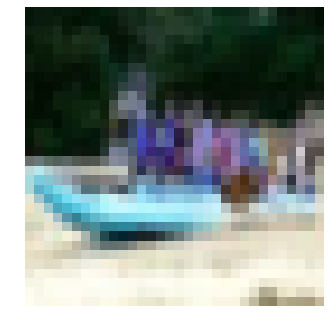

In [48]:
(text, notext) = model.predict(image)[0]
print("text" if text > notext else "notext")

plt.imshow(orig)
plt.axis('off')
plt.show()